# Iberdrola Project - Phase 2 [Occupancy Detection]

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
2.1.2+cu121


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())
print(tf.config.list_physical_devices('GPU'))

2024-08-25 10:48:44.110900: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-25 10:48:44.153248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 10:48:44.153308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 10:48:44.156087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 10:48:44.170675: I tensorflow/core/platform/cpu_feature_guar

2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-08-25 10:48:46.457889: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-25 10:48:46.463570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-25 10:48:46.463608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Import Libraries

In [3]:
import os
import h5py
import scipy
import random
import pickle
import json
import configparser
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.io import loadmat, savemat
from pathlib import Path
from tqdm import tqdm
from scipy import stats
from random import shuffle

In [4]:
%matplotlib inline
sns.set_style('white')

# Import and Prepare Data

## House 01

Import Data and Check for NaNs and InFs

In [5]:
# Import
fl_Data_H01 = h5py.File(os.path.join('Raw_Data/Phase_2_Exp_2/H01_Data_Matched_Occupancy.mat'), 'r')
print(fl_Data_H01.keys())
# Extract
Data_Plugs_H01 = np.swapaxes(np.swapaxes(np.array(fl_Data_H01['data_plugs']),0,1),1,2)
print(Data_Plugs_H01.shape)
Data_SM_H01 = np.swapaxes(np.swapaxes(np.array(fl_Data_H01['data_sm']),0,1),1,2)
print(Data_SM_H01.shape)
Data_DT_H01 = np.int_(np.swapaxes(np.swapaxes(np.array(fl_Data_H01['data_datetime']),0,1),1,2))
print(Data_DT_H01.shape)
Data_Ocp_H01 = np.int_(np.expand_dims(np.array(fl_Data_H01['data_occupancy']), axis=2))
print(Data_Ocp_H01.shape)
del fl_Data_H01
sample_num = Data_Plugs_H01.shape[0]
segment_length = Data_Plugs_H01.shape[1]
num_channels = Data_Plugs_H01.shape[2]
# Check for NaNs and InFs
print(pd.Series(Data_Plugs_H01.ravel()).isna().any())
print(pd.Series(Data_Plugs_H01.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_SM_H01.ravel()).isna().any())
print(pd.Series(Data_SM_H01.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_DT_H01.ravel()).isna().any())
print(pd.Series(Data_DT_H01.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_Ocp_H01.ravel()).isna().any())
print(pd.Series(Data_Ocp_H01.ravel()).isin([np.inf, -np.inf]).any())

<KeysViewHDF5 ['data_datetime', 'data_occupancy', 'data_plugs', 'data_sm']>
(85, 86400, 7)
(85, 86400, 7)
(85, 86400, 8)
(85, 86400, 1)
False
False
False
False
False
False
False
False


Preprocess Data

In [6]:
# Remove irrelevant channels
print('##### - Removing irrelevant channels - #####')
thresh0 = 0.05
Data_Plugs_H01_Pruned = np.zeros((sample_num,segment_length,num_channels))
device_list = ['Fridge','Dryer','Kitchen_Appliances','Kettle','Washing_Machine','PC_Router','Freezer']
counter = 0
for i in range(0,num_channels):
    data_current_channel = Data_Plugs_H01[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Data_Ocp_H01.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh0) or (i == 0) or (i == 6):
        continue
    else:
        Data_Plugs_H01_Pruned[:,:,counter] = data_current_channel
        print(device_list[i])
        print(data_current_channel_corr)
        counter = counter + 1
Data_Plugs_H01_Pruned = Data_Plugs_H01_Pruned[:,:,0:counter]
print(Data_Plugs_H01_Pruned.shape)
# Generate Load Event Pulses per channel
print('##### - Generating Load Event Pulses per Channel - #####')
Data_Plugs_H01_Pulses = np.zeros((sample_num,segment_length,Data_Plugs_H01_Pruned.shape[2]))
counter = 0
thresh1 = 0
for i in range(0,sample_num):
    X_Data_Temp = Data_Plugs_H01_Pruned[i,:,:]
    for ii in range(0,Data_Plugs_H01_Pruned.shape[2]):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        for iii in range(0,segment_length):
            X_Data_Temp_Ch_Point = X_Data_Temp_Ch[iii]
            if X_Data_Temp_Ch_Point > thresh1:
                X_Data_Temp_Ch_Point = 1
            Data_Plugs_H01_Pulses[counter,iii,ii] = X_Data_Temp_Ch_Point
    counter = counter + 1
Data_Plugs_H01_Pulses = np.int_(Data_Plugs_H01_Pulses[0:counter,:,:])
print(Data_Plugs_H01_Pulses.shape)
print(np.unique(Data_Plugs_H01_Pulses))
# Aggregate Device Load Pulses
print('##### - Aggregating Device Load Pulses - #####')
Data_Plugs_H01_Pulses_AGG = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = Data_Plugs_H01_Pulses[i,:,:]
    X_Data_Temp = np.sum(X_Data_Temp, axis=1)
    X_Data_Temp[X_Data_Temp > 0] = 1
    Data_Plugs_H01_Pulses_AGG[counter,:,0] = X_Data_Temp
    counter = counter + 1
Data_Plugs_H01_Pulses_AGG = np.int_(Data_Plugs_H01_Pulses_AGG[0:counter,:,:])
print(Data_Plugs_H01_Pulses_AGG.shape)
print(np.unique(Data_Plugs_H01_Pulses_AGG))
# Curate Aggregated Pulses
print('##### - Curating Aggregated Pulses - #####')
Data_Plugs_H01_Curated = np.zeros((sample_num,segment_length,Data_Plugs_H01_Pruned.shape[2]))
Data_Plugs_H01_Pulses_AGG_Curated = np.zeros((sample_num,segment_length,1))
Data_SM_H01_Curated = np.zeros((sample_num,segment_length,7))
Data_DT_H01_Curated = np.zeros((sample_num,segment_length,8))
Data_Ocp_H01_Curated = np.zeros((sample_num,segment_length,1))
thresh2 = 1800
thresh3 = 1800
counter = 0
for i in range(0,sample_num):
    Data_Plugs_H01_Temp = Data_Plugs_H01_Pruned[i,:,:]
    Data_Plugs_H01_Pulses_AGG_Temp = Data_Plugs_H01_Pulses_AGG[i,:,:]
    Data_SM_H01_Temp = Data_SM_H01[i,:,:]
    Data_DT_H01_Temp = Data_DT_H01[i,:,:]
    Data_Ocp_H01_Temp = Data_Ocp_H01[i,:,:]
    Data_Ocp_H01_Temp_SUM = np.sum(Data_Ocp_H01_Temp)
    transition_points = []
    for ii in range(1,segment_length):
        Temp_Previous_Point = Data_Plugs_H01_Pulses_AGG_Temp[ii-1]
        Temp_Next_Point = Data_Plugs_H01_Pulses_AGG_Temp[ii]
        if Temp_Previous_Point != Temp_Next_Point:
            transition_points.append(ii)
    if len(transition_points) > 0:
        for ii in range(1,len(transition_points)):
            transition_interval = np.int_(transition_points[ii] - transition_points[ii-1])
            if transition_interval <= thresh2:
                Data_Plugs_H01_Pulses_AGG_Temp[transition_points[ii-1]:transition_points[ii]] = 0
    transition_points = []
    for ii in range(1,segment_length):
        Temp_Previous_Point = Data_Plugs_H01_Pulses_AGG_Temp[ii-1]
        Temp_Next_Point = Data_Plugs_H01_Pulses_AGG_Temp[ii]
        if Temp_Previous_Point != Temp_Next_Point:
            transition_points.append(ii)
    if len(transition_points) > 0:
        for ii in range(1,len(transition_points)):
            transition_interval = np.int_(transition_points[ii] - transition_points[ii-1])
            if transition_interval <= thresh3:
                Data_Plugs_H01_Pulses_AGG_Temp[transition_points[ii-1]:transition_points[ii]] = 1
    if (Data_Ocp_H01_Temp_SUM <= np.round(0.1*segment_length)) or (Data_Ocp_H01_Temp_SUM >= np.round(0.9*segment_length)):
        continue
    if (np.var(Data_Plugs_H01_Pulses_AGG_Temp) > 0.0001):
        Data_Plugs_H01_Curated[counter,:,:] = Data_Plugs_H01_Temp
        Data_Plugs_H01_Pulses_AGG_Curated[counter,:,:] = Data_Plugs_H01_Pulses_AGG_Temp
        Data_SM_H01_Curated[counter,:,:] = Data_SM_H01_Temp
        Data_DT_H01_Curated[counter,:,:] = Data_DT_H01_Temp
        Data_Ocp_H01_Curated[counter,:,:] = Data_Ocp_H01_Temp
        counter = counter + 1
Data_Plugs_H01_Curated = Data_Plugs_H01_Curated[0:counter,:,:]
Data_Plugs_H01_Pulses_AGG_Curated = np.int_(Data_Plugs_H01_Pulses_AGG_Curated[0:counter,:,:])
Data_SM_H01_Curated = Data_SM_H01_Curated[0:counter,:,:]
Data_DT_H01_Curated = np.int_(Data_DT_H01_Curated[0:counter,:,:])
Data_Ocp_H01_Curated = np.int_(Data_Ocp_H01_Curated[0:counter,:,:])
# Print
print(Data_Plugs_H01_Curated.shape)
print(Data_Plugs_H01_Pulses_AGG_Curated.shape)
print(Data_SM_H01_Curated.shape)
print(Data_DT_H01_Curated.shape)
print(Data_Ocp_H01_Curated.shape)
print(np.unique(Data_Plugs_H01_Pulses_AGG_Curated))
print(np.unique(Data_Ocp_H01_Curated))
# Save
hfilew = h5py.File('Occupancy_Data_Curated_H01.h5','w')
hfilew.create_dataset('Data_Plugs_H01_Curated', data=Data_Plugs_H01_Curated)
hfilew.create_dataset('Data_Plugs_H01_Pulses_AGG_Curated', data=Data_Plugs_H01_Pulses_AGG_Curated)
hfilew.create_dataset('Data_SM_H01_Curated', data=Data_SM_H01_Curated)
hfilew.create_dataset('Data_DT_H01_Curated', data=Data_DT_H01_Curated)
hfilew.create_dataset('Data_Ocp_H01_Curated', data=Data_Ocp_H01_Curated)
hfilew.close()

##### - Removing irrelevant channels - #####
Dryer
0.06496729060568185
(85, 86400, 1)
##### - Generating Load Event Pulses per Channel - #####
(85, 86400, 1)
[0 1]
##### - Aggregating Device Load Pulses - #####
(85, 86400, 1)
[0 1]
##### - Curating Aggregated Pulses - #####
(12, 86400, 1)
(12, 86400, 1)
(12, 86400, 7)
(12, 86400, 8)
(12, 86400, 1)
[0 1]
[0 1]


Plot

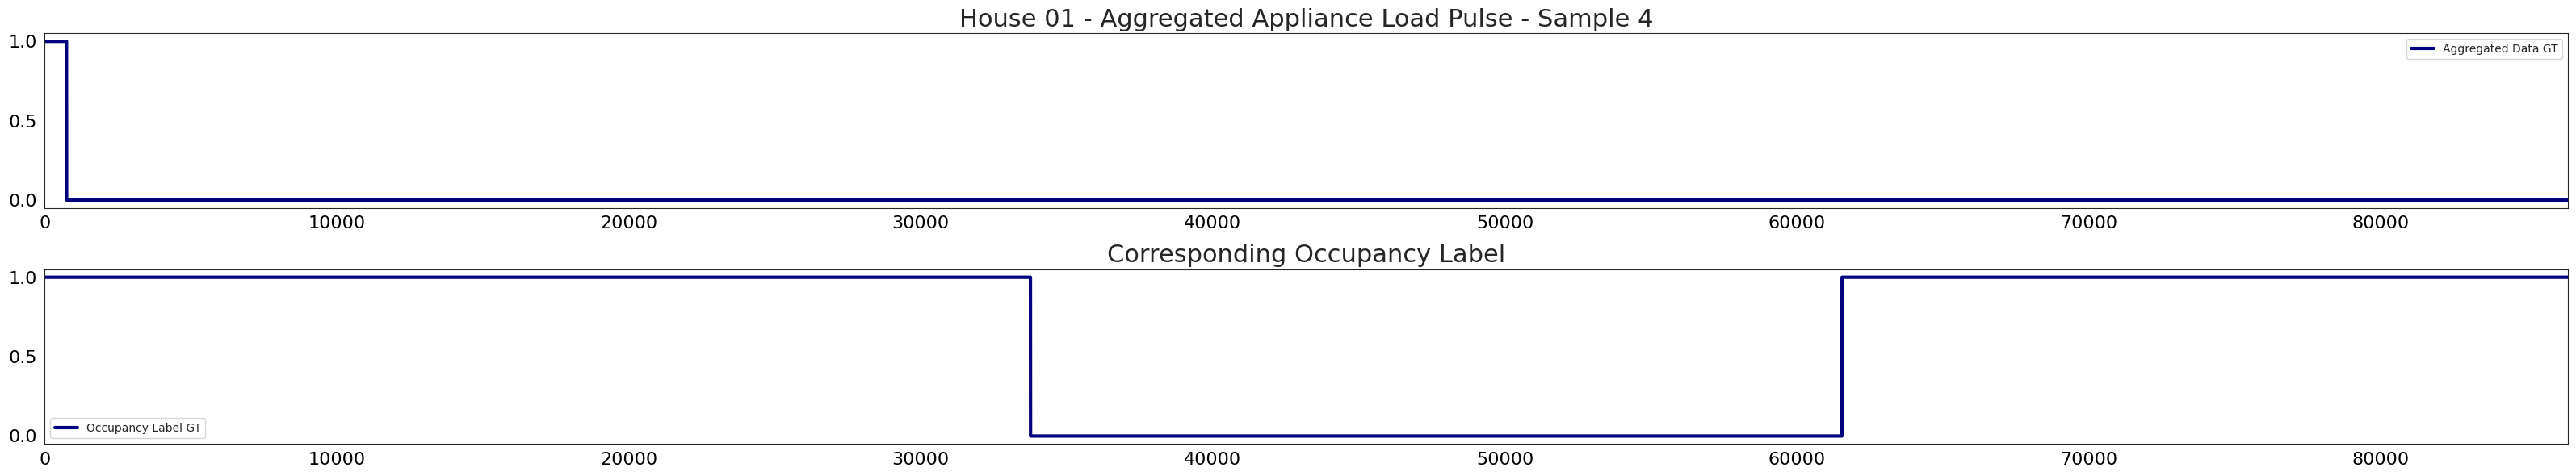

In [6]:
segment_length = 86400
i = random.randint(0, Data_Plugs_H01_Pulses_AGG_Curated.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(Data_Plugs_H01_Pulses_AGG_Curated[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House 01 - Aggregated Appliance Load Pulse - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Data_Ocp_H01_Curated[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Corresponding Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

## House 02

Import Data and Check for NaNs and InFs

In [7]:
# Import
fl_Data_H02 = h5py.File(os.path.join('Raw_Data/Phase_2_Exp_2/H02_Data_Matched_Occupancy.mat'), 'r')
print(fl_Data_H02.keys())
# Extract
Data_Plugs_H02 = np.swapaxes(np.swapaxes(np.array(fl_Data_H02['data_plugs']),0,1),1,2)
print(Data_Plugs_H02.shape)
Data_SM_H02 = np.swapaxes(np.swapaxes(np.array(fl_Data_H02['data_sm']),0,1),1,2)
print(Data_SM_H02.shape)
Data_DT_H02 = np.int_(np.swapaxes(np.swapaxes(np.array(fl_Data_H02['data_datetime']),0,1),1,2))
print(Data_DT_H02.shape)
Data_Ocp_H02 = np.int_(np.expand_dims(np.array(fl_Data_H02['data_occupancy']), axis=2))
print(Data_Ocp_H02.shape)
del fl_Data_H02
sample_num = Data_Plugs_H02.shape[0]
segment_length = Data_Plugs_H02.shape[1]
num_channels = Data_Plugs_H02.shape[2]
# Check for NaNs and InFs
print(pd.Series(Data_Plugs_H02.ravel()).isna().any())
print(pd.Series(Data_Plugs_H02.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_SM_H02.ravel()).isna().any())
print(pd.Series(Data_SM_H02.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_DT_H02.ravel()).isna().any())
print(pd.Series(Data_DT_H02.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_Ocp_H02.ravel()).isna().any())
print(pd.Series(Data_Ocp_H02.ravel()).isin([np.inf, -np.inf]).any())

<KeysViewHDF5 ['data_datetime', 'data_occupancy', 'data_plugs', 'data_sm']>
(128, 86400, 9)
(128, 86400, 7)
(128, 86400, 8)
(128, 86400, 1)
False
False
False
False
False
False
False
False


Preprocess Data

In [8]:
# Remove irrelevant channels
print('##### - Removing irrelevant channels - #####')
thresh0 = 0.05
Data_Plugs_H02_Pruned = np.zeros((sample_num,segment_length,num_channels))
device_list = ['Dishwasher','Air_Exhaust','Fridge','Entertainment','Freezer','Kettle','Lamp','Laptop','Stove']
counter = 0
for i in range(0,num_channels):
    data_current_channel = Data_Plugs_H02[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Data_Ocp_H02.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh0) or (i == 2) or (i == 4):
        continue
    else:
        Data_Plugs_H02_Pruned[:,:,counter] = data_current_channel
        print(device_list[i])
        print(data_current_channel_corr)
        counter = counter + 1
Data_Plugs_H02_Pruned = Data_Plugs_H02_Pruned[:,:,0:counter]
print(Data_Plugs_H02_Pruned.shape)
# Generate Load Event Pulses per channel
print('##### - Generating Load Event Pulses per Channel - #####')
Data_Plugs_H02_Pulses = np.zeros((sample_num,segment_length,Data_Plugs_H02_Pruned.shape[2]))
counter = 0
thresh1 = 0
for i in range(0,sample_num):
    X_Data_Temp = Data_Plugs_H02_Pruned[i,:,:]
    for ii in range(0,Data_Plugs_H02_Pruned.shape[2]):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        for iii in range(0,segment_length):
            X_Data_Temp_Ch_Point = X_Data_Temp_Ch[iii]
            if X_Data_Temp_Ch_Point > thresh1:
                X_Data_Temp_Ch_Point = 1
            Data_Plugs_H02_Pulses[counter,iii,ii] = X_Data_Temp_Ch_Point
    counter = counter + 1
Data_Plugs_H02_Pulses = np.int_(Data_Plugs_H02_Pulses[0:counter,:,:])
print(Data_Plugs_H02_Pulses.shape)
print(np.unique(Data_Plugs_H02_Pulses))
# Aggregate Device Load Pulses
print('##### - Aggregating Device Load Pulses - #####')
Data_Plugs_H02_Pulses_AGG = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = Data_Plugs_H02_Pulses[i,:,:]
    X_Data_Temp = np.sum(X_Data_Temp, axis=1)
    X_Data_Temp[X_Data_Temp > 0] = 1
    Data_Plugs_H02_Pulses_AGG[counter,:,0] = X_Data_Temp
    counter = counter + 1
Data_Plugs_H02_Pulses_AGG = np.int_(Data_Plugs_H02_Pulses_AGG[0:counter,:,:])
print(Data_Plugs_H02_Pulses_AGG.shape)
print(np.unique(Data_Plugs_H02_Pulses_AGG))
# Curate Aggregated Pulses
print('##### - Curating Aggregated Pulses - #####')
Data_Plugs_H02_Curated = np.zeros((sample_num,segment_length,Data_Plugs_H02_Pruned.shape[2]))
Data_Plugs_H02_Pulses_AGG_Curated = np.zeros((sample_num,segment_length,1))
Data_SM_H02_Curated = np.zeros((sample_num,segment_length,7))
Data_DT_H02_Curated = np.zeros((sample_num,segment_length,8))
Data_Ocp_H02_Curated = np.zeros((sample_num,segment_length,1))
thresh2 = 1800
thresh3 = 1800
counter = 0
for i in range(0,sample_num):
    Data_Plugs_H02_Temp = Data_Plugs_H02_Pruned[i,:,:]
    Data_Plugs_H02_Pulses_AGG_Temp = Data_Plugs_H02_Pulses_AGG[i,:,:]
    Data_SM_H02_Temp = Data_SM_H02[i,:,:]
    Data_DT_H02_Temp = Data_DT_H02[i,:,:]
    Data_Ocp_H02_Temp = Data_Ocp_H02[i,:,:]
    Data_Ocp_H02_Temp_SUM = np.sum(Data_Ocp_H02_Temp)
    transition_points = []
    for ii in range(1,segment_length):
        Temp_Previous_Point = Data_Plugs_H02_Pulses_AGG_Temp[ii-1]
        Temp_Next_Point = Data_Plugs_H02_Pulses_AGG_Temp[ii]
        if Temp_Previous_Point != Temp_Next_Point:
            transition_points.append(ii)
    if len(transition_points) > 0:
        for ii in range(1,len(transition_points)):
            transition_interval = np.int_(transition_points[ii] - transition_points[ii-1])
            if transition_interval <= thresh2:
                Data_Plugs_H02_Pulses_AGG_Temp[transition_points[ii-1]:transition_points[ii]] = 0
    transition_points = []
    for ii in range(1,segment_length):
        Temp_Previous_Point = Data_Plugs_H02_Pulses_AGG_Temp[ii-1]
        Temp_Next_Point = Data_Plugs_H02_Pulses_AGG_Temp[ii]
        if Temp_Previous_Point != Temp_Next_Point:
            transition_points.append(ii)
    if len(transition_points) > 0:
        for ii in range(1,len(transition_points)):
            transition_interval = np.int_(transition_points[ii] - transition_points[ii-1])
            if transition_interval <= thresh3:
                Data_Plugs_H02_Pulses_AGG_Temp[transition_points[ii-1]:transition_points[ii]] = 1
    if (Data_Ocp_H02_Temp_SUM <= np.round(0.1*segment_length)) or (Data_Ocp_H02_Temp_SUM >= np.round(0.9*segment_length)):
        continue
    if (np.var(Data_Plugs_H02_Pulses_AGG_Temp) > 0.0001):
        Data_Plugs_H02_Curated[counter,:,:] = Data_Plugs_H02_Temp
        Data_Plugs_H02_Pulses_AGG_Curated[counter,:,:] = Data_Plugs_H02_Pulses_AGG_Temp
        Data_SM_H02_Curated[counter,:,:] = Data_SM_H02_Temp
        Data_DT_H02_Curated[counter,:,:] = Data_DT_H02_Temp
        Data_Ocp_H02_Curated[counter,:,:] = Data_Ocp_H02_Temp
        counter = counter + 1
Data_Plugs_H02_Curated = Data_Plugs_H02_Curated[0:counter,:,:]
Data_Plugs_H02_Pulses_AGG_Curated = np.int_(Data_Plugs_H02_Pulses_AGG_Curated[0:counter,:,:])
Data_SM_H02_Curated = Data_SM_H02_Curated[0:counter,:,:]
Data_DT_H02_Curated = np.int_(Data_DT_H02_Curated[0:counter,:,:])
Data_Ocp_H02_Curated = np.int_(Data_Ocp_H02_Curated[0:counter,:,:])
# Print
print(Data_Plugs_H02_Curated.shape)
print(Data_Plugs_H02_Pulses_AGG_Curated.shape)
print(Data_SM_H02_Curated.shape)
print(Data_DT_H02_Curated.shape)
print(Data_Ocp_H02_Curated.shape)
print(np.unique(Data_Plugs_H02_Pulses_AGG_Curated))
print(np.unique(Data_Ocp_H02_Curated))
# Save
hfilew = h5py.File('Occupancy_Data_Curated_H02.h5','w')
hfilew.create_dataset('Data_Plugs_H02_Curated', data=Data_Plugs_H02_Curated)
hfilew.create_dataset('Data_Plugs_H02_Pulses_AGG_Curated', data=Data_Plugs_H02_Pulses_AGG_Curated)
hfilew.create_dataset('Data_SM_H02_Curated', data=Data_SM_H02_Curated)
hfilew.create_dataset('Data_DT_H02_Curated', data=Data_DT_H02_Curated)
hfilew.create_dataset('Data_Ocp_H02_Curated', data=Data_Ocp_H02_Curated)
hfilew.close()

##### - Removing irrelevant channels - #####
Air_Exhaust
0.053250558718312184
Entertainment
0.3623027807084419
Lamp
0.17230365164718126
Laptop
0.240410696871534
(128, 86400, 4)
##### - Generating Load Event Pulses per Channel - #####
(128, 86400, 4)
[0 1]
##### - Aggregating Device Load Pulses - #####
(128, 86400, 1)
[0 1]
##### - Curating Aggregated Pulses - #####
(84, 86400, 4)
(84, 86400, 1)
(84, 86400, 7)
(84, 86400, 8)
(84, 86400, 1)
[0 1]
[0 1]


Plot

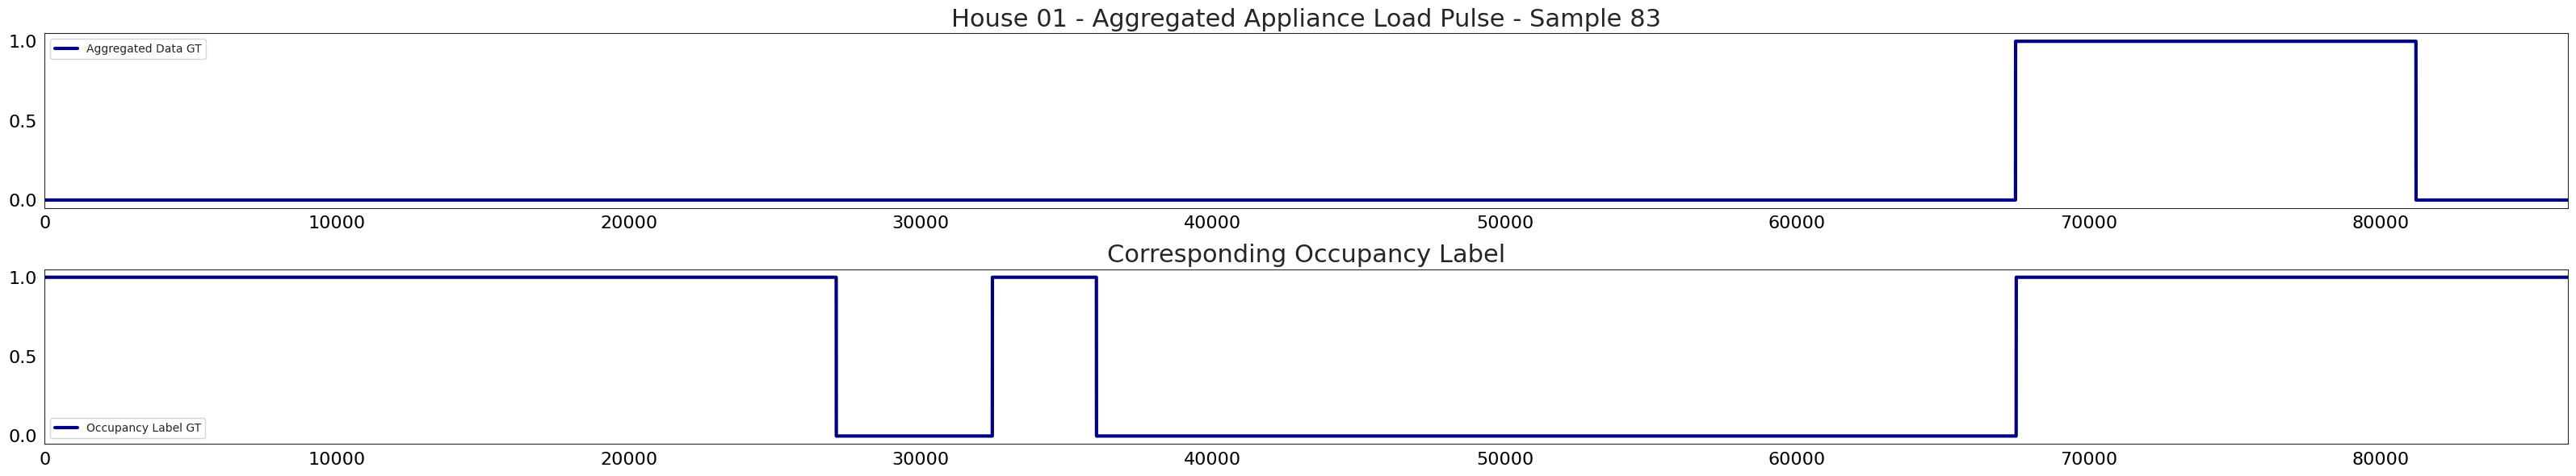

In [9]:
segment_length = 86400
i = random.randint(0, Data_Plugs_H02_Pulses_AGG_Curated.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(Data_Plugs_H02_Pulses_AGG_Curated[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House 01 - Aggregated Appliance Load Pulse - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Data_Ocp_H02_Curated[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Corresponding Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

## House 03

Import Data and Check for NaNs and InFs

In [9]:
# Import
fl_Data_H03 = h5py.File(os.path.join('Raw_Data/Phase_2_Exp_2/H03_Data_Matched_Occupancy.mat'), 'r')
print(fl_Data_H03.keys())
# Extract
Data_Plugs_H03 = np.swapaxes(np.swapaxes(np.array(fl_Data_H03['data_plugs']),0,1),1,2)
print(Data_Plugs_H03.shape)
Data_SM_H03 = np.swapaxes(np.swapaxes(np.array(fl_Data_H03['data_sm']),0,1),1,2)
print(Data_SM_H03.shape)
Data_DT_H03 = np.int_(np.swapaxes(np.swapaxes(np.array(fl_Data_H03['data_datetime']),0,1),1,2))
print(Data_DT_H03.shape)
Data_Ocp_H03 = np.int_(np.expand_dims(np.array(fl_Data_H03['data_occupancy']), axis=2))
print(Data_Ocp_H03.shape)
del fl_Data_H03
sample_num = Data_Plugs_H03.shape[0]
segment_length = Data_Plugs_H03.shape[1]
num_channels = Data_Plugs_H03.shape[2]
# Check for NaNs and InFs
print(pd.Series(Data_Plugs_H03.ravel()).isna().any())
print(pd.Series(Data_Plugs_H03.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_SM_H03.ravel()).isna().any())
print(pd.Series(Data_SM_H03.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_DT_H03.ravel()).isna().any())
print(pd.Series(Data_DT_H03.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_Ocp_H03.ravel()).isna().any())
print(pd.Series(Data_Ocp_H03.ravel()).isin([np.inf, -np.inf]).any())

<KeysViewHDF5 ['data_datetime', 'data_occupancy', 'data_plugs', 'data_sm']>
(78, 86400, 6)
(78, 86400, 7)
(78, 86400, 8)
(78, 86400, 1)
False
False
False
False
False
False
False
False


Preprocess Data

In [10]:
# Remove irrelevant channels
print('##### - Removing irrelevant channels - #####')
thresh0 = 0.05
Data_Plugs_H03_Pruned = np.zeros((sample_num,segment_length,num_channels))
device_list = ['Freezer','Kitchen Appliances','PC and Router','Fridge','Entertainment']
counter = 0
for i in range(0,num_channels):
    data_current_channel = Data_Plugs_H03[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Data_Ocp_H03.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh0) or (i == 0) or (i == 3):
        continue
    else:
        Data_Plugs_H03_Pruned[:,:,counter] = data_current_channel
        print(device_list[i])
        print(data_current_channel_corr)
        counter = counter + 1
Data_Plugs_H03_Pruned = Data_Plugs_H03_Pruned[:,:,0:counter]
print(Data_Plugs_H03_Pruned.shape)
# Generate Load Event Pulses per channel
print('##### - Generating Load Event Pulses per Channel - #####')
Data_Plugs_H03_Pulses = np.zeros((sample_num,segment_length,Data_Plugs_H03_Pruned.shape[2]))
counter = 0
thresh1 = 0
for i in range(0,sample_num):
    X_Data_Temp = Data_Plugs_H03_Pruned[i,:,:]
    for ii in range(0,Data_Plugs_H03_Pruned.shape[2]):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        for iii in range(0,segment_length):
            X_Data_Temp_Ch_Point = X_Data_Temp_Ch[iii]
            if X_Data_Temp_Ch_Point > thresh1:
                X_Data_Temp_Ch_Point = 1
            Data_Plugs_H03_Pulses[counter,iii,ii] = X_Data_Temp_Ch_Point
    counter = counter + 1
Data_Plugs_H03_Pulses = np.int_(Data_Plugs_H03_Pulses[0:counter,:,:])
print(Data_Plugs_H03_Pulses.shape)
print(np.unique(Data_Plugs_H03_Pulses))
# Aggregate Device Load Pulses
print('##### - Aggregating Device Load Pulses - #####')
Data_Plugs_H03_Pulses_AGG = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = Data_Plugs_H03_Pulses[i,:,:]
    X_Data_Temp = np.sum(X_Data_Temp, axis=1)
    X_Data_Temp[X_Data_Temp > 0] = 1
    Data_Plugs_H03_Pulses_AGG[counter,:,0] = X_Data_Temp
    counter = counter + 1
Data_Plugs_H03_Pulses_AGG = np.int_(Data_Plugs_H03_Pulses_AGG[0:counter,:,:])
print(Data_Plugs_H03_Pulses_AGG.shape)
print(np.unique(Data_Plugs_H03_Pulses_AGG))
# Curate Aggregated Pulses
print('##### - Curating Aggregated Pulses - #####')
Data_Plugs_H03_Curated = np.zeros((sample_num,segment_length,Data_Plugs_H03_Pruned.shape[2]))
Data_Plugs_H03_Pulses_AGG_Curated = np.zeros((sample_num,segment_length,1))
Data_SM_H03_Curated = np.zeros((sample_num,segment_length,7))
Data_DT_H03_Curated = np.zeros((sample_num,segment_length,8))
Data_Ocp_H03_Curated = np.zeros((sample_num,segment_length,1))
thresh2 = 1800
thresh3 = 1800
counter = 0
for i in range(0,sample_num):
    Data_Plugs_H03_Temp = Data_Plugs_H03_Pruned[i,:,:]
    Data_Plugs_H03_Pulses_AGG_Temp = Data_Plugs_H03_Pulses_AGG[i,:,:]
    Data_SM_H03_Temp = Data_SM_H03[i,:,:]
    Data_DT_H03_Temp = Data_DT_H03[i,:,:]
    Data_Ocp_H03_Temp = Data_Ocp_H03[i,:,:]
    Data_Ocp_H03_Temp_SUM = np.sum(Data_Ocp_H03_Temp)
    transition_points = []
    for ii in range(1,segment_length):
        Temp_Previous_Point = Data_Plugs_H03_Pulses_AGG_Temp[ii-1]
        Temp_Next_Point = Data_Plugs_H03_Pulses_AGG_Temp[ii]
        if Temp_Previous_Point != Temp_Next_Point:
            transition_points.append(ii)
    if len(transition_points) > 0:
        for ii in range(1,len(transition_points)):
            transition_interval = np.int_(transition_points[ii] - transition_points[ii-1])
            if transition_interval <= thresh2:
                Data_Plugs_H03_Pulses_AGG_Temp[transition_points[ii-1]:transition_points[ii]] = 0
    transition_points = []
    for ii in range(1,segment_length):
        Temp_Previous_Point = Data_Plugs_H03_Pulses_AGG_Temp[ii-1]
        Temp_Next_Point = Data_Plugs_H03_Pulses_AGG_Temp[ii]
        if Temp_Previous_Point != Temp_Next_Point:
            transition_points.append(ii)
    if len(transition_points) > 0:
        for ii in range(1,len(transition_points)):
            transition_interval = np.int_(transition_points[ii] - transition_points[ii-1])
            if transition_interval <= thresh3:
                Data_Plugs_H03_Pulses_AGG_Temp[transition_points[ii-1]:transition_points[ii]] = 1
    if (Data_Ocp_H03_Temp_SUM <= np.round(0.1*segment_length)) or (Data_Ocp_H03_Temp_SUM >= np.round(0.9*segment_length)):
        continue
    if (np.var(Data_Plugs_H03_Pulses_AGG_Temp) > 0.0001):
        Data_Plugs_H03_Curated[counter,:,:] = Data_Plugs_H03_Temp
        Data_Plugs_H03_Pulses_AGG_Curated[counter,:,:] = Data_Plugs_H03_Pulses_AGG_Temp
        Data_SM_H03_Curated[counter,:,:] = Data_SM_H03_Temp
        Data_DT_H03_Curated[counter,:,:] = Data_DT_H03_Temp
        Data_Ocp_H03_Curated[counter,:,:] = Data_Ocp_H03_Temp
        counter = counter + 1
Data_Plugs_H03_Curated = Data_Plugs_H03_Curated[0:counter,:,:]
Data_Plugs_H03_Pulses_AGG_Curated = np.int_(Data_Plugs_H03_Pulses_AGG_Curated[0:counter,:,:])
Data_SM_H03_Curated = Data_SM_H03_Curated[0:counter,:,:]
Data_DT_H03_Curated = np.int_(Data_DT_H03_Curated[0:counter,:,:])
Data_Ocp_H03_Curated = np.int_(Data_Ocp_H03_Curated[0:counter,:,:])
# Print
print(Data_Plugs_H03_Curated.shape)
print(Data_Plugs_H03_Pulses_AGG_Curated.shape)
print(Data_SM_H03_Curated.shape)
print(Data_DT_H03_Curated.shape)
print(Data_Ocp_H03_Curated.shape)
print(np.unique(Data_Plugs_H03_Pulses_AGG_Curated))
print(np.unique(Data_Ocp_H03_Curated))
# Save
hfilew = h5py.File('Occupancy_Data_Curated_H03.h5','w')
hfilew.create_dataset('Data_Plugs_H03_Curated', data=Data_Plugs_H03_Curated)
hfilew.create_dataset('Data_Plugs_H03_Pulses_AGG_Curated', data=Data_Plugs_H03_Pulses_AGG_Curated)
hfilew.create_dataset('Data_SM_H03_Curated', data=Data_SM_H03_Curated)
hfilew.create_dataset('Data_DT_H03_Curated', data=Data_DT_H03_Curated)
hfilew.create_dataset('Data_Ocp_H03_Curated', data=Data_Ocp_H03_Curated)
hfilew.close()

##### - Removing irrelevant channels - #####


/root/miniconda3/envs/wsl_miniconda_env1/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Entertainment
nan
(78, 86400, 1)
##### - Generating Load Event Pulses per Channel - #####
(78, 86400, 1)
[0]
##### - Aggregating Device Load Pulses - #####
(78, 86400, 1)
[0]
##### - Curating Aggregated Pulses - #####
(0, 86400, 1)
(0, 86400, 1)
(0, 86400, 7)
(0, 86400, 8)
(0, 86400, 1)
[]
[]


## House 04

Import Data and Check for NaNs and InFs

In [11]:
# Import
fl_Data_H04 = h5py.File(os.path.join('Raw_Data/Phase_2_Exp_2/H04_Data_Matched_Occupancy.mat'), 'r')
print(fl_Data_H04.keys())
# Extract
Data_Plugs_H04 = np.swapaxes(np.swapaxes(np.array(fl_Data_H04['data_plugs']),0,1),1,2)
print(Data_Plugs_H04.shape)
Data_SM_H04 = np.swapaxes(np.swapaxes(np.array(fl_Data_H04['data_sm']),0,1),1,2)
print(Data_SM_H04.shape)
Data_DT_H04 = np.int_(np.swapaxes(np.swapaxes(np.array(fl_Data_H04['data_datetime']),0,1),1,2))
print(Data_DT_H04.shape)
Data_Ocp_H04 = np.int_(np.expand_dims(np.array(fl_Data_H04['data_occupancy']), axis=2))
print(Data_Ocp_H04.shape)
del fl_Data_H04
sample_num = Data_Plugs_H04.shape[0]
segment_length = Data_Plugs_H04.shape[1]
num_channels = Data_Plugs_H04.shape[2]
# Check for NaNs and InFs
print(pd.Series(Data_Plugs_H04.ravel()).isna().any())
print(pd.Series(Data_Plugs_H04.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_SM_H04.ravel()).isna().any())
print(pd.Series(Data_SM_H04.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_DT_H04.ravel()).isna().any())
print(pd.Series(Data_DT_H04.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_Ocp_H04.ravel()).isna().any())
print(pd.Series(Data_Ocp_H04.ravel()).isin([np.inf, -np.inf]).any())

<KeysViewHDF5 ['data_datetime', 'data_occupancy', 'data_plugs', 'data_sm']>
(86, 86400, 7)
(86, 86400, 7)
(86, 86400, 8)
(86, 86400, 1)
False
False
False
False
False
False
False
False


Preprocess Data

In [12]:
# Remove irrelevant channels
print('##### - Removing irrelevant channels - #####')
thresh0 = 0.05
Data_Plugs_H04_Pruned = np.zeros((sample_num,segment_length,num_channels))
device_list = ['Fridge','Kitchen_Appliances','Lamp','Laptop','Freezer','Entertainment','Microwave']
counter = 0
for i in range(0,num_channels):
    data_current_channel = Data_Plugs_H04[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Data_Ocp_H04.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh0) or (i == 0) or (i == 4):
        continue
    else:
        Data_Plugs_H04_Pruned[:,:,counter] = data_current_channel
        print(device_list[i])
        print(data_current_channel_corr)
        counter = counter + 1
Data_Plugs_H04_Pruned = Data_Plugs_H04_Pruned[:,:,0:counter]
print(Data_Plugs_H04_Pruned.shape)
# Generate Load Event Pulses per channel
print('##### - Generating Load Event Pulses per Channel - #####')
Data_Plugs_H04_Pulses = np.zeros((sample_num,segment_length,Data_Plugs_H04_Pruned.shape[2]))
counter = 0
thresh1 = 0
for i in range(0,sample_num):
    X_Data_Temp = Data_Plugs_H04_Pruned[i,:,:]
    for ii in range(0,Data_Plugs_H04_Pruned.shape[2]):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        for iii in range(0,segment_length):
            X_Data_Temp_Ch_Point = X_Data_Temp_Ch[iii]
            if X_Data_Temp_Ch_Point > thresh1:
                X_Data_Temp_Ch_Point = 1
            Data_Plugs_H04_Pulses[counter,iii,ii] = X_Data_Temp_Ch_Point
    counter = counter + 1
Data_Plugs_H04_Pulses = np.int_(Data_Plugs_H04_Pulses[0:counter,:,:])
print(Data_Plugs_H04_Pulses.shape)
print(np.unique(Data_Plugs_H04_Pulses))
# Aggregate Device Load Pulses
print('##### - Aggregating Device Load Pulses - #####')
Data_Plugs_H04_Pulses_AGG = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = Data_Plugs_H04_Pulses[i,:,:]
    X_Data_Temp = np.sum(X_Data_Temp, axis=1)
    X_Data_Temp[X_Data_Temp > 0] = 1
    Data_Plugs_H04_Pulses_AGG[counter,:,0] = X_Data_Temp
    counter = counter + 1
Data_Plugs_H04_Pulses_AGG = np.int_(Data_Plugs_H04_Pulses_AGG[0:counter,:,:])
print(Data_Plugs_H04_Pulses_AGG.shape)
print(np.unique(Data_Plugs_H04_Pulses_AGG))
# Curate Aggregated Pulses
print('##### - Curating Aggregated Pulses - #####')
Data_Plugs_H04_Curated = np.zeros((sample_num,segment_length,Data_Plugs_H04_Pruned.shape[2]))
Data_Plugs_H04_Pulses_AGG_Curated = np.zeros((sample_num,segment_length,1))
Data_SM_H04_Curated = np.zeros((sample_num,segment_length,7))
Data_DT_H04_Curated = np.zeros((sample_num,segment_length,8))
Data_Ocp_H04_Curated = np.zeros((sample_num,segment_length,1))
thresh2 = 1800
thresh3 = 1800
counter = 0
for i in range(0,sample_num):
    Data_Plugs_H04_Temp = Data_Plugs_H04_Pruned[i,:,:]
    Data_Plugs_H04_Pulses_AGG_Temp = Data_Plugs_H04_Pulses_AGG[i,:,:]
    Data_SM_H04_Temp = Data_SM_H04[i,:,:]
    Data_DT_H04_Temp = Data_DT_H04[i,:,:]
    Data_Ocp_H04_Temp = Data_Ocp_H04[i,:,:]
    Data_Ocp_H04_Temp_SUM = np.sum(Data_Ocp_H04_Temp)
    transition_points = []
    for ii in range(1,segment_length):
        Temp_Previous_Point = Data_Plugs_H04_Pulses_AGG_Temp[ii-1]
        Temp_Next_Point = Data_Plugs_H04_Pulses_AGG_Temp[ii]
        if Temp_Previous_Point != Temp_Next_Point:
            transition_points.append(ii)
    if len(transition_points) > 0:
        for ii in range(1,len(transition_points)):
            transition_interval = np.int_(transition_points[ii] - transition_points[ii-1])
            if transition_interval <= thresh2:
                Data_Plugs_H04_Pulses_AGG_Temp[transition_points[ii-1]:transition_points[ii]] = 0
    transition_points = []
    for ii in range(1,segment_length):
        Temp_Previous_Point = Data_Plugs_H04_Pulses_AGG_Temp[ii-1]
        Temp_Next_Point = Data_Plugs_H04_Pulses_AGG_Temp[ii]
        if Temp_Previous_Point != Temp_Next_Point:
            transition_points.append(ii)
    if len(transition_points) > 0:
        for ii in range(1,len(transition_points)):
            transition_interval = np.int_(transition_points[ii] - transition_points[ii-1])
            if transition_interval <= thresh3:
                Data_Plugs_H04_Pulses_AGG_Temp[transition_points[ii-1]:transition_points[ii]] = 1
    if (Data_Ocp_H04_Temp_SUM <= np.round(0.1*segment_length)) or (Data_Ocp_H04_Temp_SUM >= np.round(0.9*segment_length)):
        continue
    if (np.var(Data_Plugs_H04_Pulses_AGG_Temp) > 0.0001):
        Data_Plugs_H04_Curated[counter,:,:] = Data_Plugs_H04_Temp
        Data_Plugs_H04_Pulses_AGG_Curated[counter,:,:] = Data_Plugs_H04_Pulses_AGG_Temp
        Data_SM_H04_Curated[counter,:,:] = Data_SM_H04_Temp
        Data_DT_H04_Curated[counter,:,:] = Data_DT_H04_Temp
        Data_Ocp_H04_Curated[counter,:,:] = Data_Ocp_H04_Temp
        counter = counter + 1
Data_Plugs_H04_Curated = Data_Plugs_H04_Curated[0:counter,:,:]
Data_Plugs_H04_Pulses_AGG_Curated = np.int_(Data_Plugs_H04_Pulses_AGG_Curated[0:counter,:,:])
Data_SM_H04_Curated = Data_SM_H04_Curated[0:counter,:,:]
Data_DT_H04_Curated = np.int_(Data_DT_H04_Curated[0:counter,:,:])
Data_Ocp_H04_Curated = np.int_(Data_Ocp_H04_Curated[0:counter,:,:])
# Print
print(Data_Plugs_H04_Curated.shape)
print(Data_Plugs_H04_Pulses_AGG_Curated.shape)
print(Data_SM_H04_Curated.shape)
print(Data_DT_H04_Curated.shape)
print(Data_Ocp_H04_Curated.shape)
print(np.unique(Data_Plugs_H04_Pulses_AGG_Curated))
print(np.unique(Data_Ocp_H04_Curated))
# Save
hfilew = h5py.File('Occupancy_Data_Curated_H04.h5','w')
hfilew.create_dataset('Data_Plugs_H04_Curated', data=Data_Plugs_H04_Curated)
hfilew.create_dataset('Data_Plugs_H04_Pulses_AGG_Curated', data=Data_Plugs_H04_Pulses_AGG_Curated)
hfilew.create_dataset('Data_SM_H04_Curated', data=Data_SM_H04_Curated)
hfilew.create_dataset('Data_DT_H04_Curated', data=Data_DT_H04_Curated)
hfilew.create_dataset('Data_Ocp_H04_Curated', data=Data_Ocp_H04_Curated)
hfilew.close()

##### - Removing irrelevant channels - #####
Entertainment
0.12176916668629403
(86, 86400, 1)
##### - Generating Load Event Pulses per Channel - #####
(86, 86400, 1)
[0 1]
##### - Aggregating Device Load Pulses - #####
(86, 86400, 1)
[0 1]
##### - Curating Aggregated Pulses - #####
(17, 86400, 1)
(17, 86400, 1)
(17, 86400, 7)
(17, 86400, 8)
(17, 86400, 1)
[0 1]
[0 1]


Plot

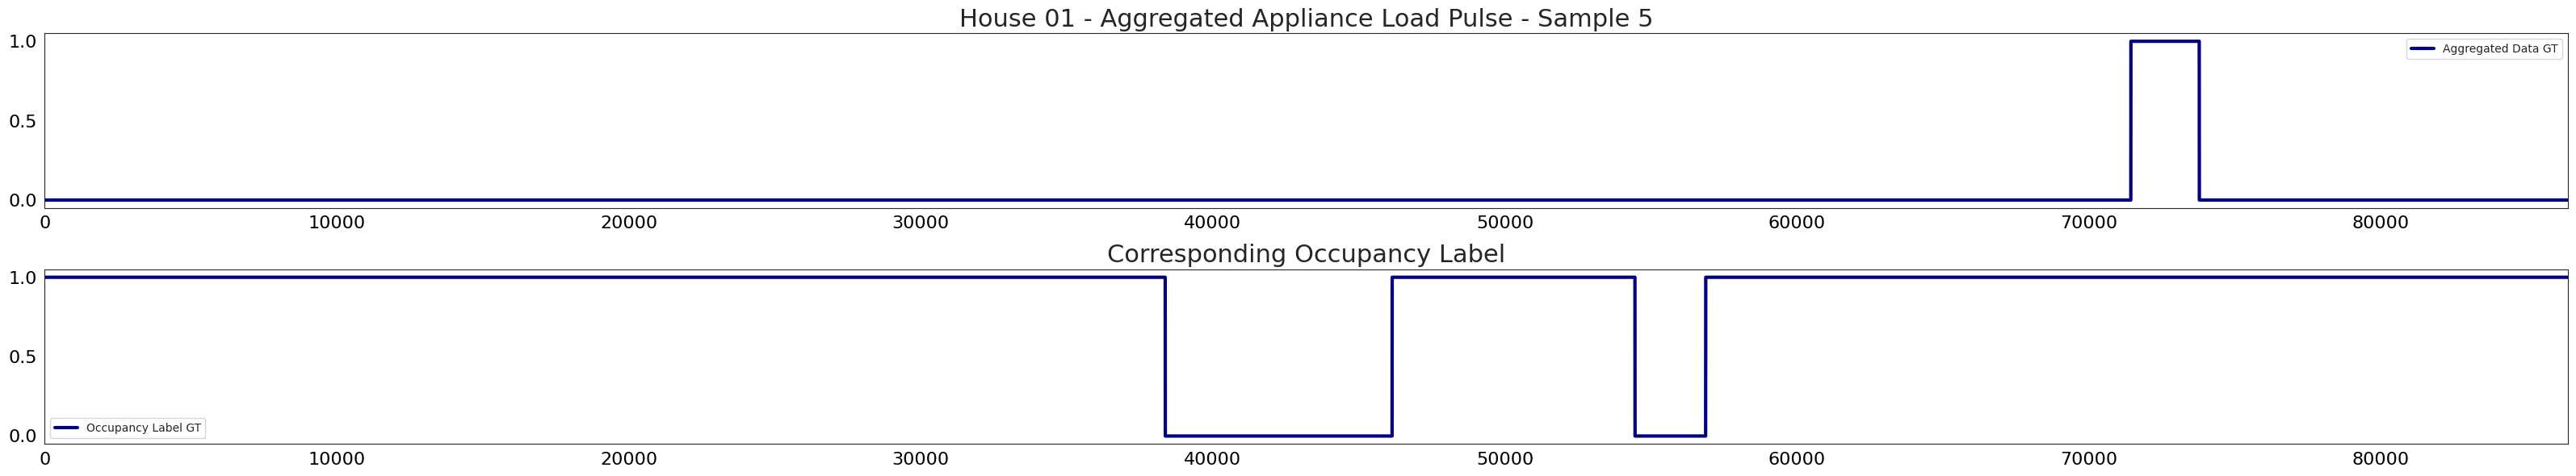

In [15]:
segment_length = 86400
i = random.randint(0, Data_Plugs_H04_Pulses_AGG_Curated.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(Data_Plugs_H04_Pulses_AGG_Curated[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House 01 - Aggregated Appliance Load Pulse - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Data_Ocp_H04_Curated[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Corresponding Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

## House 05

Import Data and Check for NaNs and InFs

In [13]:
# Import
fl_Data_H05 = h5py.File(os.path.join('Raw_Data/Phase_2_Exp_2/H05_Data_Matched_Occupancy.mat'), 'r')
print(fl_Data_H05.keys())
# Extract
Data_Plugs_H05 = np.swapaxes(np.swapaxes(np.array(fl_Data_H05['data_plugs']),0,1),1,2)
print(Data_Plugs_H05.shape)
Data_SM_H05 = np.swapaxes(np.swapaxes(np.array(fl_Data_H05['data_sm']),0,1),1,2)
print(Data_SM_H05.shape)
Data_DT_H05 = np.int_(np.swapaxes(np.swapaxes(np.array(fl_Data_H05['data_datetime']),0,1),1,2))
print(Data_DT_H05.shape)
Data_Ocp_H05 = np.int_(np.expand_dims(np.array(fl_Data_H05['data_occupancy']), axis=2))
print(Data_Ocp_H05.shape)
del fl_Data_H05
sample_num = Data_Plugs_H05.shape[0]
segment_length = Data_Plugs_H05.shape[1]
num_channels = Data_Plugs_H05.shape[2]
# Check for NaNs and InFs
print(pd.Series(Data_Plugs_H05.ravel()).isna().any())
print(pd.Series(Data_Plugs_H05.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_SM_H05.ravel()).isna().any())
print(pd.Series(Data_SM_H05.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_DT_H05.ravel()).isna().any())
print(pd.Series(Data_DT_H05.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_Ocp_H05.ravel()).isna().any())
print(pd.Series(Data_Ocp_H05.ravel()).isin([np.inf, -np.inf]).any())

<KeysViewHDF5 ['data_datetime', 'data_occupancy', 'data_plugs', 'data_sm']>
(74, 86400, 6)
(74, 86400, 7)
(74, 86400, 8)
(74, 86400, 1)
False
False
False
False
False
False
False
False


Preprocess Data

In [14]:
# Remove irrelevant channels
print('##### - Removing irrelevant channels - #####')
thresh0 = 0.05
Data_Plugs_H05_Pruned = np.zeros((sample_num,segment_length,num_channels))
device_list = ['Kitchen Appliances','Microwave','Fridge','Entertainment','PC and Router','Kettle']
counter = 0
for i in range(0,num_channels):
    data_current_channel = Data_Plugs_H05[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Data_Ocp_H05.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh0) or (i == 2):
        continue
    else:
        Data_Plugs_H05_Pruned[:,:,counter] = data_current_channel
        print(device_list[i])
        print(data_current_channel_corr)
        counter = counter + 1
Data_Plugs_H05_Pruned = Data_Plugs_H05_Pruned[:,:,0:counter]
print(Data_Plugs_H05_Pruned.shape)
# Generate Load Event Pulses per channel
print('##### - Generating Load Event Pulses per Channel - #####')
Data_Plugs_H05_Pulses = np.zeros((sample_num,segment_length,Data_Plugs_H05_Pruned.shape[2]))
counter = 0
thresh1 = 0
for i in range(0,sample_num):
    X_Data_Temp = Data_Plugs_H05_Pruned[i,:,:]
    for ii in range(0,Data_Plugs_H05_Pruned.shape[2]):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        for iii in range(0,segment_length):
            X_Data_Temp_Ch_Point = X_Data_Temp_Ch[iii]
            if X_Data_Temp_Ch_Point > thresh1:
                X_Data_Temp_Ch_Point = 1
            Data_Plugs_H05_Pulses[counter,iii,ii] = X_Data_Temp_Ch_Point
    counter = counter + 1
Data_Plugs_H05_Pulses = np.int_(Data_Plugs_H05_Pulses[0:counter,:,:])
print(Data_Plugs_H05_Pulses.shape)
print(np.unique(Data_Plugs_H05_Pulses))
# Aggregate Device Load Pulses
print('##### - Aggregating Device Load Pulses - #####')
Data_Plugs_H05_Pulses_AGG = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = Data_Plugs_H05_Pulses[i,:,:]
    X_Data_Temp = np.sum(X_Data_Temp, axis=1)
    X_Data_Temp[X_Data_Temp > 0] = 1
    Data_Plugs_H05_Pulses_AGG[counter,:,0] = X_Data_Temp
    counter = counter + 1
Data_Plugs_H05_Pulses_AGG = np.int_(Data_Plugs_H05_Pulses_AGG[0:counter,:,:])
print(Data_Plugs_H05_Pulses_AGG.shape)
print(np.unique(Data_Plugs_H05_Pulses_AGG))
# Curate Aggregated Pulses
print('##### - Curating Aggregated Pulses - #####')
Data_Plugs_H05_Curated = np.zeros((sample_num,segment_length,Data_Plugs_H05_Pruned.shape[2]))
Data_Plugs_H05_Pulses_AGG_Curated = np.zeros((sample_num,segment_length,1))
Data_SM_H05_Curated = np.zeros((sample_num,segment_length,7))
Data_DT_H05_Curated = np.zeros((sample_num,segment_length,8))
Data_Ocp_H05_Curated = np.zeros((sample_num,segment_length,1))
thresh2 = 1800
thresh3 = 1800
counter = 0
for i in range(0,sample_num):
    Data_Plugs_H05_Temp = Data_Plugs_H05_Pruned[i,:,:]
    Data_Plugs_H05_Pulses_AGG_Temp = Data_Plugs_H05_Pulses_AGG[i,:,:]
    Data_SM_H05_Temp = Data_SM_H05[i,:,:]
    Data_DT_H05_Temp = Data_DT_H05[i,:,:]
    Data_Ocp_H05_Temp = Data_Ocp_H05[i,:,:]
    Data_Ocp_H05_Temp_SUM = np.sum(Data_Ocp_H05_Temp)
    transition_points = []
    for ii in range(1,segment_length):
        Temp_Previous_Point = Data_Plugs_H05_Pulses_AGG_Temp[ii-1]
        Temp_Next_Point = Data_Plugs_H05_Pulses_AGG_Temp[ii]
        if Temp_Previous_Point != Temp_Next_Point:
            transition_points.append(ii)
    if len(transition_points) > 0:
        for ii in range(1,len(transition_points)):
            transition_interval = np.int_(transition_points[ii] - transition_points[ii-1])
            if transition_interval <= thresh2:
                Data_Plugs_H05_Pulses_AGG_Temp[transition_points[ii-1]:transition_points[ii]] = 0
    transition_points = []
    for ii in range(1,segment_length):
        Temp_Previous_Point = Data_Plugs_H05_Pulses_AGG_Temp[ii-1]
        Temp_Next_Point = Data_Plugs_H05_Pulses_AGG_Temp[ii]
        if Temp_Previous_Point != Temp_Next_Point:
            transition_points.append(ii)
    if len(transition_points) > 0:
        for ii in range(1,len(transition_points)):
            transition_interval = np.int_(transition_points[ii] - transition_points[ii-1])
            if transition_interval <= thresh3:
                Data_Plugs_H05_Pulses_AGG_Temp[transition_points[ii-1]:transition_points[ii]] = 1
    if (Data_Ocp_H05_Temp_SUM <= np.round(0.1*segment_length)) or (Data_Ocp_H05_Temp_SUM >= np.round(0.9*segment_length)):
        continue
    if (np.var(Data_Plugs_H05_Pulses_AGG_Temp) > 0.0001):
        Data_Plugs_H05_Curated[counter,:,:] = Data_Plugs_H05_Temp
        Data_Plugs_H05_Pulses_AGG_Curated[counter,:,:] = Data_Plugs_H05_Pulses_AGG_Temp
        Data_SM_H05_Curated[counter,:,:] = Data_SM_H05_Temp
        Data_DT_H05_Curated[counter,:,:] = Data_DT_H05_Temp
        Data_Ocp_H05_Curated[counter,:,:] = Data_Ocp_H05_Temp
        counter = counter + 1
Data_Plugs_H05_Curated = Data_Plugs_H05_Curated[0:counter,:,:]
Data_Plugs_H05_Pulses_AGG_Curated = np.int_(Data_Plugs_H05_Pulses_AGG_Curated[0:counter,:,:])
Data_SM_H05_Curated = Data_SM_H05_Curated[0:counter,:,:]
Data_DT_H05_Curated = np.int_(Data_DT_H05_Curated[0:counter,:,:])
Data_Ocp_H05_Curated = np.int_(Data_Ocp_H05_Curated[0:counter,:,:])
# Print
print(Data_Plugs_H05_Curated.shape)
print(Data_Plugs_H05_Pulses_AGG_Curated.shape)
print(Data_SM_H05_Curated.shape)
print(Data_DT_H05_Curated.shape)
print(Data_Ocp_H05_Curated.shape)
print(np.unique(Data_Plugs_H05_Pulses_AGG_Curated))
print(np.unique(Data_Ocp_H05_Curated))
# Save
hfilew = h5py.File('Occupancy_Data_Curated_H05.h5','w')
hfilew.create_dataset('Data_Plugs_H05_Curated', data=Data_Plugs_H05_Curated)
hfilew.create_dataset('Data_Plugs_H05_Pulses_AGG_Curated', data=Data_Plugs_H05_Pulses_AGG_Curated)
hfilew.create_dataset('Data_SM_H05_Curated', data=Data_SM_H05_Curated)
hfilew.create_dataset('Data_DT_H05_Curated', data=Data_DT_H05_Curated)
hfilew.create_dataset('Data_Ocp_H05_Curated', data=Data_Ocp_H05_Curated)
hfilew.close()

##### - Removing irrelevant channels - #####
Kettle
nan
(74, 86400, 1)
##### - Generating Load Event Pulses per Channel - #####
(74, 86400, 1)
[0]
##### - Aggregating Device Load Pulses - #####
(74, 86400, 1)
[0]
##### - Curating Aggregated Pulses - #####
(0, 86400, 1)
(0, 86400, 1)
(0, 86400, 7)
(0, 86400, 8)
(0, 86400, 1)
[]
[]


Plot

In [ ]:
segment_length = 86400
i = random.randint(0, Data_Plugs_H05_Pulses_AGG_Curated.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(Data_SM_H05_Curated[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House 01 - Aggregated Appliance Load Pulse - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Data_Ocp_H05_Curated[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Corresponding Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

## Combine all house data

In [15]:
## Import Data
# House 1
fl_Data_H01 = h5py.File(os.path.join('Occupancy_Data_Curated_H01.h5'), 'r')
Data_Plugs_H01_Pulses_AGG_Curated = fl_Data_H01['Data_Plugs_H01_Pulses_AGG_Curated']
Data_SM_H01_Curated = fl_Data_H01['Data_SM_H01_Curated']
Data_DT_H01_Curated = fl_Data_H01['Data_DT_H01_Curated']
Data_Ocp_H01_Curated = fl_Data_H01['Data_Ocp_H01_Curated']
Data_Plugs_H01_Curated = fl_Data_H01['Data_Plugs_H01_Curated']
# House 2
fl_Data_H02 = h5py.File(os.path.join('Occupancy_Data_Curated_H02.h5'), 'r')
Data_Plugs_H02_Pulses_AGG_Curated = fl_Data_H02['Data_Plugs_H02_Pulses_AGG_Curated']
Data_SM_H02_Curated = fl_Data_H02['Data_SM_H02_Curated']
Data_DT_H02_Curated = fl_Data_H02['Data_DT_H02_Curated']
Data_Ocp_H02_Curated = fl_Data_H02['Data_Ocp_H02_Curated']
Data_Plugs_H02_Curated = fl_Data_H02['Data_Plugs_H02_Curated']
# House 3
'''fl_Data_H03 = h5py.File(os.path.join('Occupancy_Data_Curated_H03.h5'), 'r')
Data_Plugs_H03_Pulses_AGG_Curated = fl_Data_H03['Data_Plugs_H03_Pulses_AGG_Curated']
Data_SM_H03_Curated = fl_Data_H03['Data_SM_H03_Curated']
Data_DT_H03_Curated = fl_Data_H03['Data_DT_H03_Curated']
Data_Ocp_H03_Curated = fl_Data_H03['Data_Ocp_H03_Curated']
Data_Plugs_H03_Curated = fl_Data_H03['Data_Plugs_H03_Curated']'''
# House 4
fl_Data_H04 = h5py.File(os.path.join('Occupancy_Data_Curated_H04.h5'), 'r')
Data_Plugs_H04_Pulses_AGG_Curated = fl_Data_H04['Data_Plugs_H04_Pulses_AGG_Curated']
Data_SM_H04_Curated = fl_Data_H04['Data_SM_H04_Curated']
Data_DT_H04_Curated = fl_Data_H04['Data_DT_H04_Curated']
Data_Ocp_H04_Curated = fl_Data_H04['Data_Ocp_H04_Curated']
Data_Plugs_H04_Curated = fl_Data_H04['Data_Plugs_H04_Curated']
# House 5
fl_Data_H05 = h5py.File(os.path.join('Occupancy_Data_Curated_H05.h5'), 'r')
Data_Plugs_H05_Pulses_AGG_Curated = fl_Data_H05['Data_Plugs_H05_Pulses_AGG_Curated']
Data_SM_H05_Curated = fl_Data_H05['Data_SM_H05_Curated']
Data_DT_H05_Curated = fl_Data_H05['Data_DT_H05_Curated']
Data_Ocp_H05_Curated = fl_Data_H05['Data_Ocp_H05_Curated']
Data_Plugs_H05_Curated = fl_Data_H05['Data_Plugs_H05_Curated']
# House Array
H01_array = np.ones((Data_Plugs_H01_Pulses_AGG_Curated.shape[0],1))*1
H02_array = np.ones((Data_Plugs_H02_Pulses_AGG_Curated.shape[0],1))*2
# H03_array = np.ones((Data_Plugs_H03_Pulses_AGG_Curated.shape[0],1))*3
H04_array = np.ones((Data_Plugs_H04_Pulses_AGG_Curated.shape[0],1))*4
H05_array = np.ones((Data_Plugs_H05_Pulses_AGG_Curated.shape[0],1))*5
House_array = np.int_(np.concatenate((H01_array,H02_array,H04_array,H05_array), axis=0))
# Combine
Data_Plugs_Pulses_AGG_Curated = np.concatenate((Data_Plugs_H01_Pulses_AGG_Curated,Data_Plugs_H02_Pulses_AGG_Curated,Data_Plugs_H04_Pulses_AGG_Curated,Data_Plugs_H05_Pulses_AGG_Curated), axis=0)
Data_SM_Curated = np.concatenate((Data_SM_H01_Curated,Data_SM_H02_Curated,Data_SM_H04_Curated,Data_SM_H05_Curated), axis=0)
Data_DT_Curated = np.concatenate((Data_DT_H01_Curated,Data_DT_H02_Curated,Data_DT_H04_Curated,Data_DT_H05_Curated), axis=0)
Data_Ocp_Curated = np.concatenate((Data_Ocp_H01_Curated,Data_Ocp_H02_Curated,Data_Ocp_H04_Curated,Data_Ocp_H05_Curated), axis=0)
print(Data_Plugs_Pulses_AGG_Curated.shape)
print(Data_SM_Curated.shape)
print(Data_DT_Curated.shape)
print(Data_Ocp_Curated.shape)
print(House_array.shape)
print(np.unique(Data_Plugs_Pulses_AGG_Curated))
print(np.unique(Data_Ocp_Curated))
print(np.int_(np.transpose(House_array)))
sample_num = Data_Plugs_Pulses_AGG_Curated.shape[0]
segment_length = Data_Plugs_Pulses_AGG_Curated.shape[1]
num_channels = Data_Plugs_Pulses_AGG_Curated.shape[2]
hfilew = h5py.File('Occupancy_Data_Curated_All_Houses.h5','w')
hfilew.create_dataset('Data_Plugs_H01_Curated', data=Data_Plugs_H01_Curated)
hfilew.create_dataset('Data_Plugs_H02_Curated', data=Data_Plugs_H02_Curated)
# hfilew.create_dataset('Data_Plugs_H03_Curated', data=Data_Plugs_H03_Curated)
hfilew.create_dataset('Data_Plugs_H04_Curated', data=Data_Plugs_H04_Curated)
hfilew.create_dataset('Data_Plugs_H05_Curated', data=Data_Plugs_H05_Curated)
hfilew.create_dataset('Data_Plugs_Pulses_AGG_Curated', data=Data_Plugs_Pulses_AGG_Curated)
hfilew.create_dataset('Data_SM_Curated', data=Data_SM_Curated)
hfilew.create_dataset('Data_DT_Curated', data=Data_DT_Curated)
hfilew.create_dataset('Data_Ocp_Curated', data=Data_Ocp_Curated)
hfilew.create_dataset('House_array', data=House_array)
hfilew.close()

(113, 86400, 1)
(113, 86400, 7)
(113, 86400, 8)
(113, 86400, 1)
(113, 1)
[0 1]
[0 1]
[[1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4]]


Plot Aggregated Ground Truth

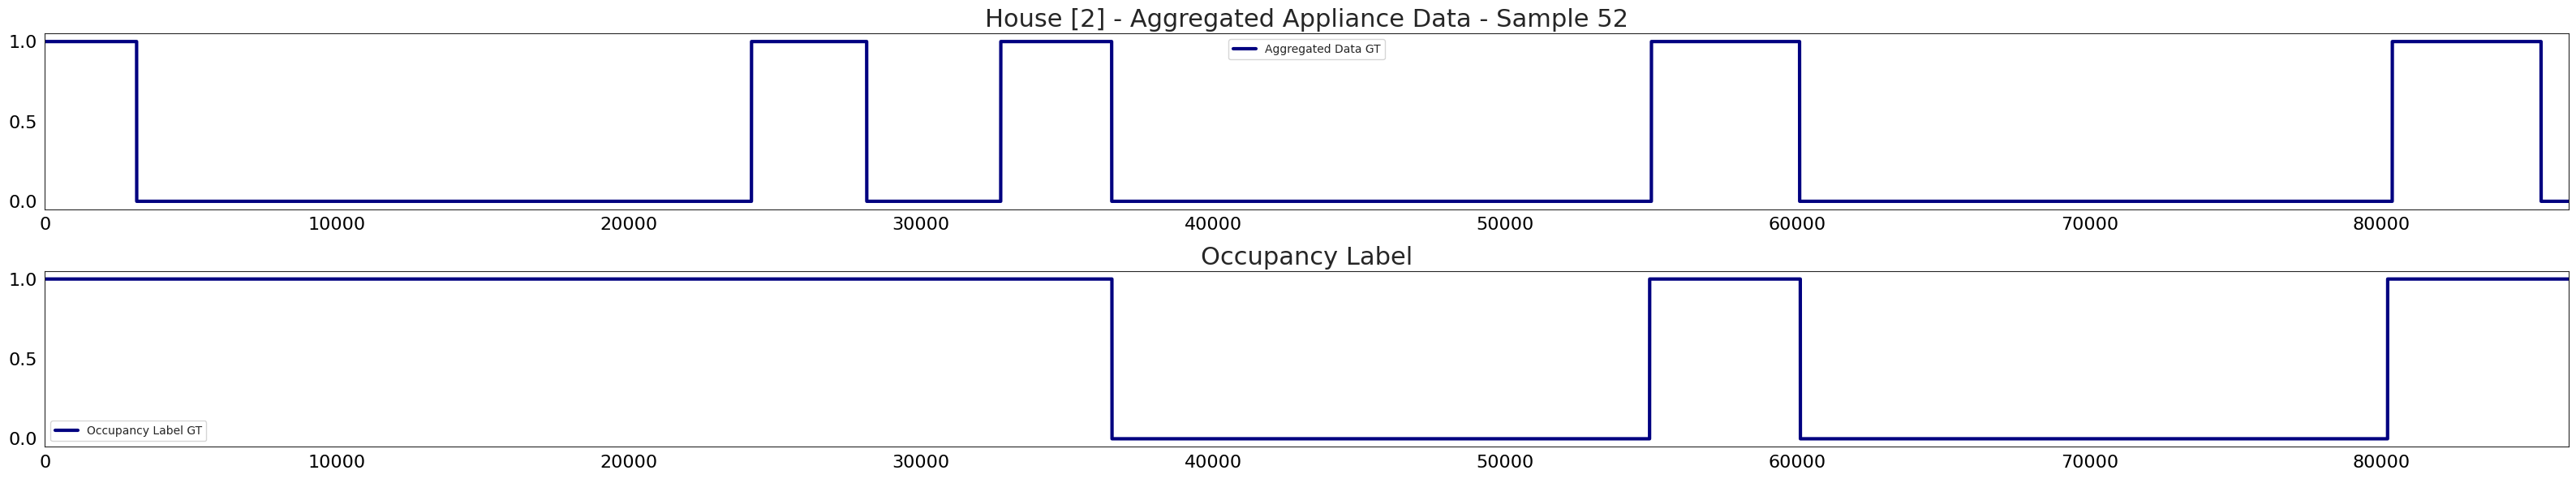

In [14]:
segment_length = 86400
i = random.randint(0, Data_Plugs_Pulses_AGG_Curated.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(Data_Plugs_Pulses_AGG_Curated[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House {np.int_(House_array[i])} - Aggregated Appliance Data - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Data_Ocp_Curated[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

## Shuffle Data

In [30]:
# Import
fl_Data = h5py.File(os.path.join('Occupancy_Data_Curated_All_Houses.h5'), 'r')
print(fl_Data.keys())
# Extract
Data_Plugs_Pulses_AGG_Curated = np.array(fl_Data['Data_Plugs_Pulses_AGG_Curated'])
print(Data_Plugs_Pulses_AGG_Curated.shape)
Data_SM_Curated = np.array(fl_Data['Data_SM_Curated'])
print(Data_SM_Curated.shape)
Data_DT_Curated = np.int_(np.array(fl_Data['Data_DT_Curated']))
print(Data_DT_Curated.shape)
Data_Ocp_Curated = np.int_(np.array(fl_Data['Data_Ocp_Curated']))
print(Data_Ocp_Curated.shape)
House_array = np.int_(np.array(fl_Data['House_array']))
print(House_array.shape)
# Transform
# Data_Plugs_H01_Curated = np.array(fl_Data['Data_Plugs_H01_Curated'])
# Data_Plugs_H02_Curated = np.array(fl_Data['Data_Plugs_H02_Curated'])
# Data_Plugs_H04_Curated = np.array(fl_Data['Data_Plugs_H04_Curated'])
# Data_Plugs_H05_Curated = np.array(fl_Data['Data_Plugs_H05_Curated'])
del fl_Data
sample_num = Data_Plugs_Pulses_AGG_Curated.shape[0]
segment_length = Data_Plugs_Pulses_AGG_Curated.shape[1]
num_channels = Data_Plugs_Pulses_AGG_Curated.shape[2]
# Check for NaNs and InFs
print(pd.Series(Data_Plugs_Pulses_AGG_Curated.ravel()).isna().any())
print(pd.Series(Data_Plugs_Pulses_AGG_Curated.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_SM_Curated.ravel()).isna().any())
print(pd.Series(Data_SM_Curated.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_DT_Curated.ravel()).isna().any())
print(pd.Series(Data_DT_Curated.ravel()).isin([np.inf, -np.inf]).any())
print(pd.Series(Data_Ocp_Curated.ravel()).isna().any())
print(pd.Series(Data_Ocp_Curated.ravel()).isin([np.inf, -np.inf]).any())
# Shuffle
ind_list = [i for i in range(sample_num)]
shuffle(ind_list)
Data_Plugs_Pulses_AGG_Shuffled = Data_Plugs_Pulses_AGG_Curated[ind_list,:,:]
Data_DT_Shuffled = Data_DT_Curated[ind_list,:,:]
Data_SM_Shuffled = Data_SM_Curated[ind_list,:,:]
Data_Ocp_Shuffled = Data_Ocp_Curated[ind_list,:,:]
House_array_Shuffled = House_array[ind_list,:]
print(Data_Plugs_Pulses_AGG_Shuffled.shape)
print(Data_DT_Shuffled.shape)
print(Data_SM_Shuffled.shape)
print(Data_Ocp_Shuffled.shape)
print(House_array_Shuffled.shape)
del Data_Plugs_Pulses_AGG_Curated, Data_SM_Curated, Data_DT_Curated, Data_Ocp_Curated

<KeysViewHDF5 ['Data_DT_Curated', 'Data_Ocp_Curated', 'Data_Plugs_H01_Curated', 'Data_Plugs_H02_Curated', 'Data_Plugs_H04_Curated', 'Data_Plugs_H05_Curated', 'Data_Plugs_Pulses_AGG_Curated', 'Data_SM_Curated', 'House_array']>
(113, 86400, 1)
(113, 86400, 7)
(113, 86400, 8)
(113, 86400, 1)
(113, 1)
False
False
False
False
False
False
False
False
(113, 86400, 1)
(113, 86400, 8)
(113, 86400, 7)
(113, 86400, 1)
(113, 1)


## Create Folds and Transform Data for Classification

In [31]:
# Configurations
segment_length = 3600  # 60 Minutes = 3600 Data Points (1 Hz sampling rate)
offset_sec = 120  # 60 seconds offset for overlapping

In [32]:
def transform_labels(A_Data, B_Data, C_Data, D_Data, segment_length, offset_amount, C1=True, C2=True):
    A_Data_New = np.zeros((40000, A_Data.shape[2], segment_length))
    B_Data_New = np.zeros((40000, B_Data.shape[2]), dtype=int)
    C_Data_New = np.zeros((40000, C_Data.shape[2]), dtype=int)
    D_Data_New = np.zeros((40000, D_Data.shape[2], segment_length))
    # Reshape Array
    A_Data_Reshaped = np.reshape(A_Data, (A_Data.shape[0]*A_Data.shape[1], A_Data.shape[2]))
    B_Data_Reshaped = np.reshape(B_Data, (B_Data.shape[0]*B_Data.shape[1], B_Data.shape[2]))
    C_Data_Reshaped = np.reshape(C_Data, (C_Data.shape[0]*C_Data.shape[1], C_Data.shape[2]))
    D_Data_Reshaped = np.reshape(D_Data, (D_Data.shape[0]*D_Data.shape[1], D_Data.shape[2]))
    ## Slide through and generate labels
    counter = 0
    for i in range(0,B_Data_Reshaped.shape[0]):
        if (i*offset_amount+segment_length) >= A_Data_Reshaped.shape[0]:
            continue
        A_Data_Temp = np.transpose(A_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:])
        # A_Data_Temp_Mean = np.mean(A_Data_Temp)
        A_Data_Temp_VAR = np.var(A_Data_Temp)
        A_Data_New[counter,:,:] = A_Data_Temp
        B_Data_Temp = B_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
        B_Data_Temp_Mean = np.mean(B_Data_Temp)
        # B_Data_Temp_VAR = np.var(B_Data_Temp)
        B_Data_Temp_SUM = np.sum(B_Data_Temp)
        if C1 == True:
            if A_Data_Temp_VAR <= 0:
                continue
        if C2 == True:
            if (B_Data_Temp_SUM < np.round(0.1*segment_length)) or (B_Data_Temp_SUM > np.round(0.9*segment_length)):
                continue
        if B_Data_Temp_Mean > 0.5:
            B_Label = 1
        else:
            B_Label = 0
        B_Data_New[counter,:] = B_Label
        C_Data_Temp = C_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
        C_Data_Temp_Mean = np.mean(C_Data_Temp, axis=0)
        C_Label = np.int_(C_Data_Temp_Mean)
        C_Data_New[counter,:] = C_Label
        D_Data_Temp = np.transpose(D_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:])
        D_Data_New[counter,:,:] = D_Data_Temp
        counter = counter + 1
    A_Data_New = A_Data_New[0:counter,:,:]
    B_Data_New = B_Data_New[0:counter,:]
    C_Data_New = C_Data_New[0:counter,:]
    D_Data_New = D_Data_New[0:counter,:,:]
    return A_Data_New, B_Data_New, C_Data_New, D_Data_New

In [ ]:
# Fold 1
Data_Plugs_Pulses_AGG_Train_F1 = Data_Plugs_Pulses_AGG_Shuffled[0:round((sample_num/5)*4),:,:]
Data_Plugs_Pulses_AGG_Test_F1 = Data_Plugs_Pulses_AGG_Shuffled[round((sample_num/5)*4):,:,:]
Data_DT_Train_F1 = Data_DT_Shuffled[0:round((sample_num/5)*4),:,:]
Data_DT_Test_F1 = Data_DT_Shuffled[round((sample_num/5)*4):,:,:]
Data_SM_Train_F1 = Data_SM_Shuffled[0:round((sample_num/5)*4),:,:]
Data_SM_Test_F1 = Data_SM_Shuffled[round((sample_num/5)*4):,:,:]
Data_Ocp_Train_F1 = Data_Ocp_Shuffled[0:round((sample_num/5)*4),:,:]
Data_Ocp_Test_F1 = Data_Ocp_Shuffled[round((sample_num/5)*4):,:,:]
HA_Train_F1 = House_array_Shuffled[0:round((sample_num/5)*4),:]
HA_Test_F1 = House_array_Shuffled[round((sample_num/5)*4):,:]
Plugs_Pulses_AGG_Train_F1_C, Ocp_Train_F1_C, DT_Train_F1_C, SM_Train_F1_C = transform_labels(Data_Plugs_Pulses_AGG_Train_F1, Data_Ocp_Train_F1, Data_DT_Train_F1, Data_SM_Train_F1, segment_length, offset_sec, True, True)
Plugs_Pulses_AGG_Test_F1_C, Ocp_Test_F1_C, DT_Test_F1_C, SM_Test_F1_C = transform_labels(Data_Plugs_Pulses_AGG_Test_F1, Data_Ocp_Test_F1, Data_DT_Test_F1, Data_SM_Test_F1, segment_length, offset_sec, True, True)
print('##### - Fold 1 - #####')
print(Plugs_Pulses_AGG_Train_F1_C.shape)
print(Ocp_Train_F1_C.shape)
print(DT_Train_F1_C.shape)
print(SM_Train_F1_C.shape)
print(Plugs_Pulses_AGG_Test_F1_C.shape)
print(Ocp_Test_F1_C.shape)
print(DT_Test_F1_C.shape)
print(SM_Test_F1_C.shape)
labels, counts = np.unique(Ocp_Train_F1_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Ocp_Test_F1_C, return_counts=True)
print(labels, counts)
del Data_Plugs_Pulses_AGG_Train_F1, Data_DT_Train_F1, Data_SM_Train_F1, Data_Ocp_Train_F1
del Data_Plugs_Pulses_AGG_Test_F1, Data_DT_Test_F1, Data_SM_Test_F1, Data_Ocp_Test_F1
hfilew = h5py.File('Occupancy_Data_Classification_Fold1.h5','w')
hfilew.create_dataset('Plugs_Pulses_AGG_Train', data=Plugs_Pulses_AGG_Train_F1_C)
hfilew.create_dataset('Ocp_Train', data=Ocp_Train_F1_C)
hfilew.create_dataset('DT_Train', data=DT_Train_F1_C)
hfilew.create_dataset('SM_Train', data=SM_Train_F1_C)
hfilew.create_dataset('Plugs_Pulses_AGG_Test', data=Plugs_Pulses_AGG_Test_F1_C)
hfilew.create_dataset('Ocp_Test', data=Ocp_Test_F1_C)
hfilew.create_dataset('DT_Test', data=DT_Test_F1_C)
hfilew.create_dataset('SM_Test', data=SM_Test_F1_C)
hfilew.close()
# Fold 2
Data_Plugs_Pulses_AGG_Train_F21 = Data_Plugs_Pulses_AGG_Shuffled[0:round((sample_num/5)*3),:,:]
Data_Plugs_Pulses_AGG_Train_F22 = Data_Plugs_Pulses_AGG_Shuffled[round((sample_num/5)*4):,:,:]
Data_Plugs_Pulses_AGG_Train_F2 = np.concatenate((Data_Plugs_Pulses_AGG_Train_F21,Data_Plugs_Pulses_AGG_Train_F22), axis=0)
Data_Plugs_Pulses_AGG_Test_F2 = Data_Plugs_Pulses_AGG_Shuffled[round((sample_num/5)*3):round((sample_num/5)*4),:,:]
Data_DT_Train_F21 = Data_DT_Shuffled[0:round((sample_num/5)*3),:,:]
Data_DT_Train_F22 = Data_DT_Shuffled[round((sample_num/5)*4):,:,:]
Data_DT_Train_F2 = np.concatenate((Data_DT_Train_F21,Data_DT_Train_F22), axis=0)
Data_DT_Test_F2 = Data_DT_Shuffled[round((sample_num/5)*3):round((sample_num/5)*4),:,:]
Data_SM_Train_F21 = Data_SM_Shuffled[0:round((sample_num/5)*3),:,:]
Data_SM_Train_F22 = Data_SM_Shuffled[round((sample_num/5)*4):,:,:]
Data_SM_Train_F2 = np.concatenate((Data_SM_Train_F21,Data_SM_Train_F22), axis=0)
Data_SM_Test_F2 = Data_SM_Shuffled[round((sample_num/5)*3):round((sample_num/5)*4),:,:]
Data_Ocp_Train_F21 = Data_Ocp_Shuffled[0:round((sample_num/5)*3),:,:]
Data_Ocp_Train_F22 = Data_Ocp_Shuffled[round((sample_num/5)*4):,:,:]
Data_Ocp_Train_F2 = np.concatenate((Data_Ocp_Train_F21,Data_Ocp_Train_F22), axis=0)
Data_Ocp_Test_F2 = Data_Ocp_Shuffled[round((sample_num/5)*3):round((sample_num/5)*4),:,:]
HA_Train_F21 = House_array_Shuffled[0:round((sample_num/5)*3),:]
HA_Train_F22 = House_array_Shuffled[round((sample_num/5)*4):,:]
HA_Train_F2 = np.concatenate((HA_Train_F21,HA_Train_F22), axis=0)
HA_Test_F2 = House_array_Shuffled[round((sample_num/5)*3):round((sample_num/5)*4),:]
Plugs_Pulses_AGG_Train_F2_C, Ocp_Train_F2_C, DT_Train_F2_C, SM_Train_F2_C = transform_labels(Data_Plugs_Pulses_AGG_Train_F2, Data_Ocp_Train_F2, Data_DT_Train_F2, Data_SM_Train_F2, segment_length, offset_sec, True, True)
Plugs_Pulses_AGG_Test_F2_C, Ocp_Test_F2_C, DT_Test_F2_C, SM_Test_F2_C = transform_labels(Data_Plugs_Pulses_AGG_Test_F2, Data_Ocp_Test_F2, Data_DT_Test_F2, Data_SM_Test_F2, segment_length, offset_sec, True, True)
print('##### - Fold 2 - #####')
print(Plugs_Pulses_AGG_Train_F2_C.shape)
print(Ocp_Train_F2_C.shape)
print(DT_Train_F2_C.shape)
print(SM_Train_F2_C.shape)
print(Plugs_Pulses_AGG_Test_F2_C.shape)
print(Ocp_Test_F2_C.shape)
print(DT_Test_F2_C.shape)
print(SM_Test_F2_C.shape)
labels, counts = np.unique(Ocp_Train_F2_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Ocp_Test_F2_C, return_counts=True)
print(labels, counts)
del Data_Plugs_Pulses_AGG_Train_F2, Data_DT_Train_F2, Data_SM_Train_F2, Data_Ocp_Train_F2
del Data_Plugs_Pulses_AGG_Test_F2, Data_DT_Test_F2, Data_SM_Test_F2, Data_Ocp_Test_F2
hfilew = h5py.File('Occupancy_Data_Classification_Fold2.h5','w')
hfilew.create_dataset('Plugs_Pulses_AGG_Train', data=Plugs_Pulses_AGG_Train_F2_C)
hfilew.create_dataset('Ocp_Train', data=Ocp_Train_F2_C)
hfilew.create_dataset('DT_Train', data=DT_Train_F2_C)
hfilew.create_dataset('SM_Train', data=SM_Train_F2_C)
hfilew.create_dataset('Plugs_Pulses_AGG_Test', data=Plugs_Pulses_AGG_Test_F2_C)
hfilew.create_dataset('Ocp_Test', data=Ocp_Test_F2_C)
hfilew.create_dataset('DT_Test', data=DT_Test_F2_C)
hfilew.create_dataset('SM_Test', data=SM_Test_F2_C)
hfilew.close()
# Fold 3
Data_Plugs_Pulses_AGG_Train_F31 = Data_Plugs_Pulses_AGG_Shuffled[0:round((sample_num/5)*2),:,:]
Data_Plugs_Pulses_AGG_Train_F32 = Data_Plugs_Pulses_AGG_Shuffled[round((sample_num/5)*3):,:,:]
Data_Plugs_Pulses_AGG_Train_F3 = np.concatenate((Data_Plugs_Pulses_AGG_Train_F31,Data_Plugs_Pulses_AGG_Train_F32), axis=0)
Data_Plugs_Pulses_AGG_Test_F3 = Data_Plugs_Pulses_AGG_Shuffled[round((sample_num/5)*2):round((sample_num/5)*3),:,:]
Data_DT_Train_F31 = Data_DT_Shuffled[0:round((sample_num/5)*2),:,:]
Data_DT_Train_F32 = Data_DT_Shuffled[round((sample_num/5)*3):,:,:]
Data_DT_Train_F3 = np.concatenate((Data_DT_Train_F31,Data_DT_Train_F32), axis=0)
Data_DT_Test_F3 = Data_DT_Shuffled[round((sample_num/5)*2):round((sample_num/5)*3),:,:]
Data_SM_Train_F31 = Data_SM_Shuffled[0:round((sample_num/5)*2),:,:]
Data_SM_Train_F32 = Data_SM_Shuffled[round((sample_num/5)*3):,:,:]
Data_SM_Train_F3 = np.concatenate((Data_SM_Train_F31,Data_SM_Train_F32), axis=0)
Data_SM_Test_F3 = Data_SM_Shuffled[round((sample_num/5)*2):round((sample_num/5)*3),:,:]
Data_Ocp_Train_F31 = Data_Ocp_Shuffled[0:round((sample_num/5)*2),:,:]
Data_Ocp_Train_F32 = Data_Ocp_Shuffled[round((sample_num/5)*3):,:,:]
Data_Ocp_Train_F3 = np.concatenate((Data_Ocp_Train_F31,Data_Ocp_Train_F32), axis=0)
Data_Ocp_Test_F3 = Data_Ocp_Shuffled[round((sample_num/5)*2):round((sample_num/5)*3),:,:]
HA_Train_F31 = House_array_Shuffled[0:round((sample_num/5)*2),:]
HA_Train_F32 = House_array_Shuffled[round((sample_num/5)*3):,:]
HA_Train_F3 = np.concatenate((HA_Train_F31,HA_Train_F32), axis=0)
HA_Test_F3 = House_array_Shuffled[round((sample_num/5)*2):round((sample_num/5)*3),:]
Plugs_Pulses_AGG_Train_F3_C, Ocp_Train_F3_C, DT_Train_F3_C, SM_Train_F3_C = transform_labels(Data_Plugs_Pulses_AGG_Train_F3, Data_Ocp_Train_F3, Data_DT_Train_F3, Data_SM_Train_F3, segment_length, offset_sec, True, True)
Plugs_Pulses_AGG_Test_F3_C, Ocp_Test_F3_C, DT_Test_F3_C, SM_Test_F3_C = transform_labels(Data_Plugs_Pulses_AGG_Test_F3, Data_Ocp_Test_F3, Data_DT_Test_F3, Data_SM_Test_F3, segment_length, offset_sec, True, True)
print('##### - Fold 3 - #####')
print(Plugs_Pulses_AGG_Train_F3_C.shape)
print(Ocp_Train_F3_C.shape)
print(DT_Train_F3_C.shape)
print(SM_Train_F3_C.shape)
print(Plugs_Pulses_AGG_Test_F3_C.shape)
print(Ocp_Test_F3_C.shape)
print(DT_Test_F3_C.shape)
print(SM_Test_F3_C.shape)
labels, counts = np.unique(Ocp_Train_F3_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Ocp_Test_F3_C, return_counts=True)
print(labels, counts)
del Data_Plugs_Pulses_AGG_Train_F3, Data_DT_Train_F3, Data_SM_Train_F3, Data_Ocp_Train_F3
del Data_Plugs_Pulses_AGG_Test_F3, Data_DT_Test_F3, Data_SM_Test_F3, Data_Ocp_Test_F3
hfilew = h5py.File('Occupancy_Data_Classification_Fold3.h5','w')
hfilew.create_dataset('Plugs_Pulses_AGG_Train', data=Plugs_Pulses_AGG_Train_F3_C)
hfilew.create_dataset('Ocp_Train', data=Ocp_Train_F3_C)
hfilew.create_dataset('DT_Train', data=DT_Train_F3_C)
hfilew.create_dataset('SM_Train', data=SM_Train_F3_C)
hfilew.create_dataset('Plugs_Pulses_AGG_Test', data=Plugs_Pulses_AGG_Test_F3_C)
hfilew.create_dataset('Ocp_Test', data=Ocp_Test_F3_C)
hfilew.create_dataset('DT_Test', data=DT_Test_F3_C)
hfilew.create_dataset('SM_Test', data=SM_Test_F3_C)
hfilew.close()
# Fold 4
Data_Plugs_Pulses_AGG_Train_F41 = Data_Plugs_Pulses_AGG_Shuffled[0:round((sample_num/5)*1),:,:]
Data_Plugs_Pulses_AGG_Train_F42 = Data_Plugs_Pulses_AGG_Shuffled[round((sample_num/5)*2):,:,:]
Data_Plugs_Pulses_AGG_Train_F4 = np.concatenate((Data_Plugs_Pulses_AGG_Train_F41,Data_Plugs_Pulses_AGG_Train_F42), axis=0)
Data_Plugs_Pulses_AGG_Test_F4 = Data_Plugs_Pulses_AGG_Shuffled[round((sample_num/5)*1):round((sample_num/5)*2),:,:]
Data_DT_Train_F41 = Data_DT_Shuffled[0:round((sample_num/5)*1),:,:]
Data_DT_Train_F42 = Data_DT_Shuffled[round((sample_num/5)*2):,:,:]
Data_DT_Train_F4 = np.concatenate((Data_DT_Train_F41,Data_DT_Train_F42), axis=0)
Data_DT_Test_F4 = Data_DT_Shuffled[round((sample_num/5)*1):round((sample_num/5)*2),:,:]
Data_SM_Train_F41 = Data_SM_Shuffled[0:round((sample_num/5)*1),:,:]
Data_SM_Train_F42 = Data_SM_Shuffled[round((sample_num/5)*2):,:,:]
Data_SM_Train_F4 = np.concatenate((Data_SM_Train_F41,Data_SM_Train_F42), axis=0)
Data_SM_Test_F4 = Data_SM_Shuffled[round((sample_num/5)*1):round((sample_num/5)*2),:,:]
Data_Ocp_Train_F41 = Data_Ocp_Shuffled[0:round((sample_num/5)*1),:,:]
Data_Ocp_Train_F42 = Data_Ocp_Shuffled[round((sample_num/5)*2):,:,:]
Data_Ocp_Train_F4 = np.concatenate((Data_Ocp_Train_F41,Data_Ocp_Train_F42), axis=0)
Data_Ocp_Test_F4 = Data_Ocp_Shuffled[round((sample_num/5)*1):round((sample_num/5)*2),:,:]
HA_Train_F41 = House_array_Shuffled[0:round((sample_num/5)*1),:]
HA_Train_F42 = House_array_Shuffled[round((sample_num/5)*2):,:]
HA_Train_F4 = np.concatenate((HA_Train_F41,HA_Train_F42), axis=0)
HA_Test_F4 = House_array_Shuffled[round((sample_num/5)*1):round((sample_num/5)*2),:]
Plugs_Pulses_AGG_Train_F4_C, Ocp_Train_F4_C, DT_Train_F4_C, SM_Train_F4_C = transform_labels(Data_Plugs_Pulses_AGG_Train_F4, Data_Ocp_Train_F4, Data_DT_Train_F4, Data_SM_Train_F4, segment_length, offset_sec, True, True)
Plugs_Pulses_AGG_Test_F4_C, Ocp_Test_F4_C, DT_Test_F4_C, SM_Test_F4_C = transform_labels(Data_Plugs_Pulses_AGG_Test_F4, Data_Ocp_Test_F4, Data_DT_Test_F4, Data_SM_Test_F4, segment_length, offset_sec, True, True)
print('##### - Fold 4 - #####')
print(Plugs_Pulses_AGG_Train_F4_C.shape)
print(Ocp_Train_F4_C.shape)
print(DT_Train_F4_C.shape)
print(SM_Train_F4_C.shape)
print(Plugs_Pulses_AGG_Test_F4_C.shape)
print(Ocp_Test_F4_C.shape)
print(DT_Test_F4_C.shape)
print(SM_Test_F4_C.shape)
labels, counts = np.unique(Ocp_Train_F4_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Ocp_Test_F4_C, return_counts=True)
print(labels, counts)
del Data_Plugs_Pulses_AGG_Train_F4, Data_DT_Train_F4, Data_SM_Train_F4, Data_Ocp_Train_F4
del Data_Plugs_Pulses_AGG_Test_F4, Data_DT_Test_F4, Data_SM_Test_F4, Data_Ocp_Test_F4
hfilew = h5py.File('Occupancy_Data_Classification_Fold4.h5','w')
hfilew.create_dataset('Plugs_Pulses_AGG_Train', data=Plugs_Pulses_AGG_Train_F4_C)
hfilew.create_dataset('Ocp_Train', data=Ocp_Train_F4_C)
hfilew.create_dataset('DT_Train', data=DT_Train_F4_C)
hfilew.create_dataset('SM_Train', data=SM_Train_F4_C)
hfilew.create_dataset('Plugs_Pulses_AGG_Test', data=Plugs_Pulses_AGG_Test_F4_C)
hfilew.create_dataset('Ocp_Test', data=Ocp_Test_F4_C)
hfilew.create_dataset('DT_Test', data=DT_Test_F4_C)
hfilew.create_dataset('SM_Test', data=SM_Test_F4_C)
hfilew.close()
# Fold 5
Data_Plugs_Pulses_AGG_Train_F5 = Data_Plugs_Pulses_AGG_Shuffled[round((sample_num/5)*1):,:,:]
Data_Plugs_Pulses_AGG_Test_F5 = Data_Plugs_Pulses_AGG_Shuffled[0:round((sample_num/5)*1),:,:]
Data_DT_Train_F5 = Data_DT_Shuffled[round((sample_num/5)*1):,:,:]
Data_DT_Test_F5 = Data_DT_Shuffled[0:round((sample_num/5)*1),:,:]
Data_SM_Train_F5 = Data_SM_Shuffled[round((sample_num/5)*1):,:,:]
Data_SM_Test_F5 = Data_SM_Shuffled[0:round((sample_num/5)*1),:,:]
Data_Ocp_Train_F5 = Data_Ocp_Shuffled[round((sample_num/5)*1):,:,:]
Data_Ocp_Test_F5 = Data_Ocp_Shuffled[0:round((sample_num/5)*1),:,:]
HA_Train_F5 = House_array_Shuffled[round((sample_num/5)*1):,:]
HA_Test_F5 = House_array_Shuffled[0:round((sample_num/5)*1),:]
Plugs_Pulses_AGG_Train_F5_C, Ocp_Train_F5_C, DT_Train_F5_C, SM_Train_F5_C = transform_labels(Data_Plugs_Pulses_AGG_Train_F5, Data_Ocp_Train_F5, Data_DT_Train_F5, Data_SM_Train_F5, segment_length, offset_sec, True, True)
Plugs_Pulses_AGG_Test_F5_C, Ocp_Test_F5_C, DT_Test_F5_C, SM_Test_F5_C = transform_labels(Data_Plugs_Pulses_AGG_Test_F5, Data_Ocp_Test_F5, Data_DT_Test_F5, Data_SM_Test_F5, segment_length, offset_sec, True, True)
print('##### - Fold 5 - #####')
print(Plugs_Pulses_AGG_Train_F5_C.shape)
print(Ocp_Train_F5_C.shape)
print(DT_Train_F5_C.shape)
print(SM_Train_F5_C.shape)
print(Plugs_Pulses_AGG_Test_F5_C.shape)
print(Ocp_Test_F5_C.shape)
print(DT_Test_F5_C.shape)
print(SM_Test_F5_C.shape)
labels, counts = np.unique(Ocp_Train_F5_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Ocp_Test_F5_C, return_counts=True)
print(labels, counts)
del Data_Plugs_Pulses_AGG_Train_F5, Data_DT_Train_F5, Data_SM_Train_F5, Data_Ocp_Train_F5
del Data_Plugs_Pulses_AGG_Test_F5, Data_DT_Test_F5, Data_SM_Test_F5, Data_Ocp_Test_F5
hfilew = h5py.File('Occupancy_Data_Classification_Fold5.h5','w')
hfilew.create_dataset('Plugs_Pulses_AGG_Train', data=Plugs_Pulses_AGG_Train_F5_C)
hfilew.create_dataset('Ocp_Train', data=Ocp_Train_F5_C)
hfilew.create_dataset('DT_Train', data=DT_Train_F5_C)
hfilew.create_dataset('SM_Train', data=SM_Train_F5_C)
hfilew.create_dataset('Plugs_Pulses_AGG_Test', data=Plugs_Pulses_AGG_Test_F5_C)
hfilew.create_dataset('Ocp_Test', data=Ocp_Test_F5_C)
hfilew.create_dataset('DT_Test', data=DT_Test_F5_C)
hfilew.create_dataset('SM_Test', data=SM_Test_F5_C)
hfilew.close()

## Load Data and Save for Training

In [46]:
fold_num = 5

In [47]:
# Import
fl_Data = h5py.File(os.path.join(f'Occupancy_Data_Classification_Fold{fold_num}.h5'),'r')
print(fl_Data.keys())
X_Train = np.array(fl_Data['Plugs_Pulses_AGG_Train'])
Y_Train = np.array(fl_Data['Ocp_Train'])
X_Test = np.array(fl_Data['Plugs_Pulses_AGG_Test'])
Y_Test = np.array(fl_Data['Ocp_Test'])
DT_Train = np.array(fl_Data['DT_Train'])
DT_Test = np.array(fl_Data['DT_Test'])
SM_Train = np.array(fl_Data['SM_Train'])
SM_Test = np.array(fl_Data['SM_Test'])
train_data_dic = {"X_Train": X_Train,
                  "Y_Train": Y_Train,
                  "X_Test": X_Test,
                  "Y_Test": Y_Test,
                  "X_Val": X_Test,
                  "Y_Val": Y_Test,
                  "DT_Train": DT_Train,
                  "DT_Test": DT_Test,
                  "SM_Train": SM_Train,
                  "SM_Test": SM_Test
                  }
savemat(f"Data/Data_Fold_{fold_num}.mat", train_data_dic, format='5')

<KeysViewHDF5 ['DT_Test', 'DT_Train', 'Ocp_Test', 'Ocp_Train', 'Plugs_Pulses_AGG_Test', 'Plugs_Pulses_AGG_Train', 'SM_Test', 'SM_Train']>


# MAIN

## Configurations

In [71]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TRAIN"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'val_size': 0.0,  # Validation percentage for splitting
    'q_order': 3,  # q-order for the Self-ONN or Super-ONN Models
    'batch_size': 16,  # Batch Size, Change to fit hardware
    'lossType': 'MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'optim_fc': 'SGD',  # 'Adam' or 'SGD'
    'lr': 0.0001,  # learning rate
    'stop_criteria': 'accuracy',  # Stopping criteria: 'loss' or 'accuracy'
    'n_epochs': 500,  # number of training epochs
    'epochs_patience': 10,
    'lr_factor': 0.1,  # lr_factor, if val loss did not decrease for a number of epochs (epochs_patience) then decrease learning rate by a factor of lr_factor
    'max_epochs_stop': 30,  # maximum number of epochs with no improvement in validation loss for early stopping
    'num_folds': 1,  # number of cross validation folds
    'load_model': False,  # load model: True or False
    'load_model_path': f'Results_Classification\ODNet_Occp_Classification\Fold_{fold_num}\ODNet_Occp_Classification_fold_{fold_num}.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'model_to_load': 'ODNet',  # choose one of the following models: 'CNN_1' 'CNN_2' 'CNN_2' 'CNN_3' 'SelfResNet18' 'ResNet'
    'model_name': 'ODNet_Occp_Classification',  # choose a unique name for result folder
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 1,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}

# SAVE CONFIG FILE
with open(r"Config_Train.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()

print("Config file 'Config_Train.ini' created")

Config file 'Config_Train.ini' created


## Train

In [ ]:
%run -i Train.py

## Test

In [73]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TEST"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'batch_size': 16,  # Batch Size, Change to fit hardware
    'lossType': 'MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'num_folds': 5,  # number of cross validation folds
    'CI': 0.9,  # Confidence interval (missied cases with probability>=CI will be reported in excel file)
    'load_model': False,  # specify path of pretrained model wieghts or set to False to train from scratch
    'load_model_path': f'Results_Classification\ODNet_Occp_Classification\Fold_1\ODNet_Occp_Classification_fold_1.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'labeled_data': True,  # set to true if you have the labeled test set
    'model_name': 'ODNet_Occp_Classification',  # name of the saved model
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 5,  # The last fold for training
    'N_steps': 1000,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}
# SAVE CONFIG FILE
with open(r"Config_Test.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()
print("Config file 'Config_Test.ini' created")

Config file 'Config_Test.ini' created


Train on GPU: True
1 GPUs detected.
Combined Evaluation of Folds 1 to 5...
#############################################################
Started fold 1
model device: cuda


Testing: 100%|██████████| 51/51 [00:07<00:00,  6.65it/s]


Test Loss: 0.5099,  Test Accuracy: 88.06%
Generating CSV Files from Individual Predictions...
Test Dataframe Write to CSV - Done
Total Inference Time: 2.4e+01 ms
Completed fold 1
#############################################################
Started fold 2
model device: cuda


Testing: 100%|██████████| 39/39 [00:06<00:00,  6.46it/s]


Test Loss: 0.5074,  Test Accuracy: 88.46%
Generating CSV Files from Individual Predictions...
Test Dataframe Write to CSV - Done
Total Inference Time: 1.4e+02 ms
Completed fold 2
#############################################################
Started fold 3
model device: cuda


Testing:  98%|█████████▊| 48/49 [00:07<00:00,  6.47it/s]/root/miniconda3/envs/wsl_miniconda_env1/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Testing: 100%|██████████| 49/49 [00:07<00:00,  6.55it/s]


Test Loss: 0.5138,  Test Accuracy: 87.91%
Generating CSV Files from Individual Predictions...
Test Dataframe Write to CSV - Done
Total Inference Time: 1.2e+01 ms
Completed fold 3
#############################################################
Started fold 4
model device: cuda


Testing: 100%|██████████| 51/51 [00:07<00:00,  6.56it/s]


Test Loss: 0.5071,  Test Accuracy: 89.15%
Generating CSV Files from Individual Predictions...
Test Dataframe Write to CSV - Done
Total Inference Time: 9.4e+01 ms
Completed fold 4
#############################################################
Started fold 5
model device: cuda


Testing: 100%|██████████| 47/47 [00:07<00:00,  6.55it/s]


Test Loss: 0.5108,  Test Accuracy: 87.52%
Generating CSV Files from Individual Predictions...
Test Dataframe Write to CSV - Done
Total Inference Time: 7.4e+01 ms
Completed fold 5
#############################################################


Combined Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]/mnt/c/Users/Sakib Mahmud/WSL_Projects/Iberdrola_Project/Test.py:401: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(missed_idx [i])
Combined Evaluation:  20%|██        | 1/5 [00:00<00:01,  2.24it/s]/mnt/c/Users/Sakib Mahmud/WSL_Projects/Iberdrola_Project/Test.py:401: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(missed_idx [i])
Combined Evaluation:  40%|████      | 2/5 [00:00<00:01,  2.66it/s]/mnt/c/Users/Sakib Mahmud/WSL_Projects/Iberdrola_Project/Test.py:401: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error



      0     1
0  1671    95
1   347  1640


                  Accuracy  Precision  Sensitivity  F1_score  Specificity
0                    88.22      82.80        94.62     88.32        82.54
1                    88.22      94.52        82.54     88.12        94.62
Weighted Average     88.22      89.01        88.22     88.21        88.94


                       
Overall_Accuracy  88.22


#############################################################


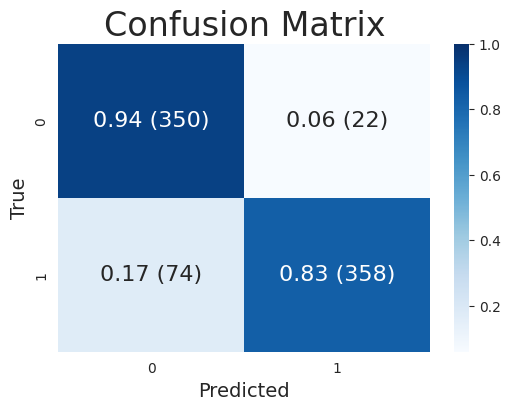

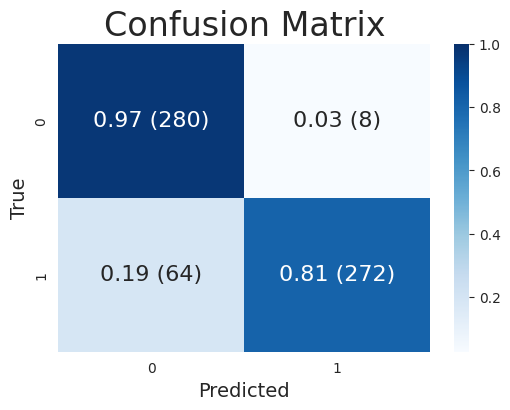

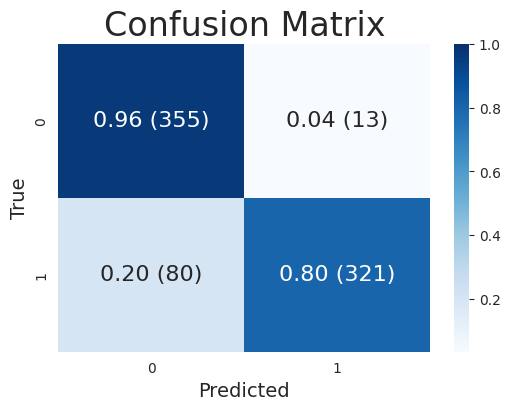

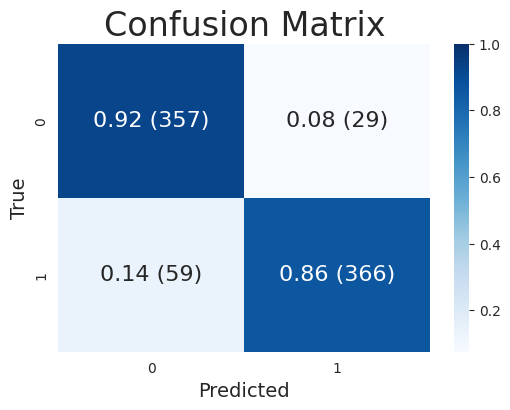

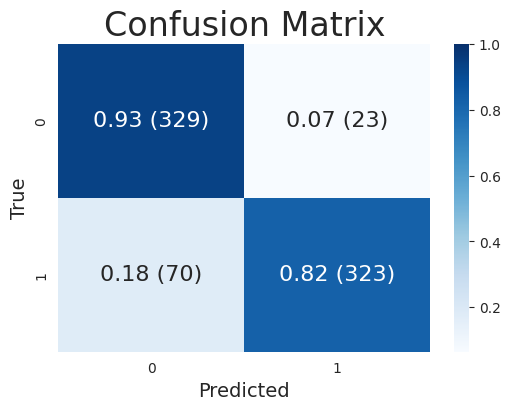

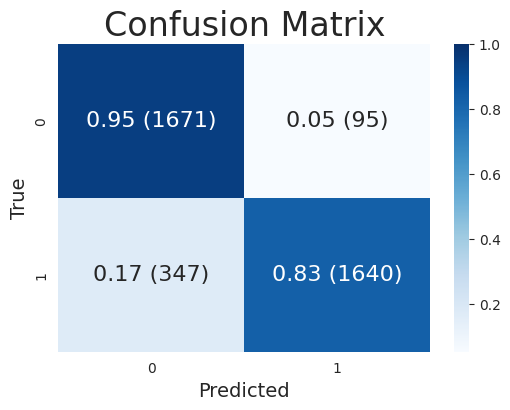

<Figure size 640x480 with 0 Axes>

In [74]:
%run -i Test.py

# Extract Features and Stack

Configuration

In [75]:
fold_num = 1

Extract Deep Features and Combine with DateTime Features

In [ ]:
import torch
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
## Load Model
saved_file = torch.load(f'Results_Classification/ODNet_OCCP_Classification/Fold_{fold_num}/ODNet_Occp_Classification_fold_{fold_num}.pt')
trained_model = saved_file['model']
# train_nodes, eval_nodes = get_graph_node_names(trained_model)
## Create Feature Extractor
return_nodes = {
    'view': 'layer1',
}
extractor_model = create_feature_extractor(trained_model, return_nodes=return_nodes)
extractor_model = extractor_model.to('cuda')
extractor_model.eval()
## Load Data
fl_Data = loadmat(os.path.join('Data', f'Data_Fold_{fold_num}.mat'))
print(fl_Data.keys())
X_Train = np.array(fl_Data['X_Train'])
Y_Train = np.array(fl_Data['Y_Train'])
DT_Train = np.array(fl_Data['DT_Train'])
## Extract Features
# Train
extracted_features_train = np.zeros((X_Train.shape[0], 256))
counter = 0
for i in range(0,X_Train.shape[0]):
    counter = counter + 1
    X_Train_Temp = torch.from_numpy(np.expand_dims(X_Train[i,:,:], axis=0))
    Y_Train_Temp = torch.from_numpy(Y_Train[i,:])
    X_Train_Temp = X_Train_Temp.to('cuda', non_blocking=True, dtype=torch.float)
    Y_Train_Temp = Y_Train_Temp.to('cuda', non_blocking=True, dtype=torch.float)
    extracted_tensor = extractor_model(X_Train_Temp)['layer1']
    extracted_features = extracted_tensor.cpu().detach().numpy()
    extracted_features_train[i,:] = extracted_features
extracted_features_train = extracted_features_train[0:counter,:]
print(extracted_features_train.shape)
index_list = []
for i in range(0,extracted_features_train.shape[1]):
    index_list.append(f'Deep_Feature_{i}')
extracted_features_train_df = pd.DataFrame(data=extracted_features_train, columns=index_list)
dt_index_list = ['year','quarter','season','month','week','day','weekend','hour']
dt_features_df = pd.DataFrame(data=DT_Train, columns=dt_index_list)
target_df = pd.DataFrame(data=Y_Train, columns=['Target'])
all_features = pd.concat([extracted_features_train_df, dt_features_df, target_df], axis=1, join="inner")
all_features.head(10)
all_features.to_excel(f"feature_list_train_fold{fold_num}.xlsx", index=False)
# Test
fl_Data = loadmat(os.path.join('Data', f'Data_Fold_{fold_num}.mat'))
X_Test = np.array(fl_Data['X_Test'])
Y_Test = np.array(fl_Data['Y_Test'])
DT_Test = np.array(fl_Data['DT_Test'])
extracted_features_test = np.zeros((X_Test.shape[0], 256))
counter = 0
for i in range(0,X_Test.shape[0]):
    counter = counter + 1
    X_Test_Temp = torch.from_numpy(np.expand_dims(X_Test[i,:,:], axis=0))
    Y_Test_Temp = torch.from_numpy(Y_Test[i,:])
    X_Test_Temp = X_Test_Temp.to('cuda', non_blocking=True, dtype=torch.float)
    Y_Test_Temp = Y_Test_Temp.to('cuda', non_blocking=True, dtype=torch.float)
    extracted_tensor = extractor_model(X_Test_Temp)['layer1']
    extracted_features = extracted_tensor.cpu().detach().numpy()
    extracted_features_test[i,:] = extracted_features
extracted_features_test = extracted_features_test[0:counter,:]
print(extracted_features_test.shape)
index_list = []
for i in range(0,extracted_features_test.shape[1]):
    index_list.append(f'Deep_Feature_{i}')
extracted_features_test_df = pd.DataFrame(data=extracted_features_test, columns=index_list)
dt_index_list = ['year','quarter','season','month','week','day','weekend','hour']
dt_features_df = pd.DataFrame(data=DT_Test, columns=dt_index_list)
target_df = pd.DataFrame(data=Y_Test, columns=['Target'])
all_features = pd.concat([extracted_features_test_df, dt_features_df, target_df], axis=1, join="inner")
all_features.head(10)
all_features.to_excel(f"feature_list_test_fold{fold_num}.xlsx", index=False)